In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

## EDA

In [2]:
# The data dictionary (compiled in MS Excel while going through the data cleaning process) will be imported below so as to ease the process of filtering columns for EDA.

data_dict = pd.read_csv("../datasets/data_dictionary.csv")
data_dict.head(10)

Column name Variable type Col dtype (initial) Col dtype (converted to)  \
0            Id      discrete               float                      NaN   
1           PID       nominal               float                      NaN   
2   MS SubClass       nominal               float                      NaN   
3     MS Zoning       nominal              object                      NaN   
4  Lot Frontage    continuous               float                      NaN   
5      Lot Area    continuous               float                      NaN   
6        Street       nominal              object                      NaN   
7         Alley       nominal              object                      NaN   
8     Lot Shape       ordinal              object                    float   
9  Land Contour       nominal              object                      NaN   

  Col dtype (final) Needs one-hot encoding  Possible unique values  \
0             float                     no                     NaN   
1             float                     no                     NaN   
2             float                    yes                    16.0   
3            object                    yes                     8.0   
4             float                     no                     NaN   
5             float                     no                     NaN   
6            object                    yes                     2.0   
7            object                    yes                     3.0   
8             float                     no                     4.0   
9            object                    yes                     4.0   

   Unique values in train  Rows of missing data  \
0                     NaN                     0   
1                     NaN                     0   
2                    16.0                     0   
3                     7.0                     0   
4                     NaN                   330   
5                     NaN                     0   
6                     2.0                     0   
7                     3.0                     0   
8                     4.0                     0   
9                     4.0                     0   

                                         Description  
0                                Observation number.  
1                      Parcel identification number.  
2  Identifies the type of dwelling involved in th...  
3  Identifies the general zoning classification o...  
4       Linear feet of street connected to property.  
5                           Lot size in square feet.  
6                   Type of road access to property.  
7                  Type of alley access to property.  
8  General shape of property. 'Reg' = 4, 'IR1' = ...  
9                          Flatness of the property.

In [3]:
# Read train_cleaned.csv and assign it to a dataframe 'c_train'.
# keep_default_na=False because train_claned.csv has a few object columns which have 'NA' values which have meanings.
# We need to avoid these 'NA' values from being wrongly read as empty NaN values by default.
# Only missing values (blank in the CSV file) should be identified as NaN values.

c_train = pd.read_csv('../datasets/train_cleaned.csv', keep_default_na=False)

In [4]:
c_train.shape

(2044, 81)

In [5]:
# Similar to what was done during the data cleaning process, notice that some columns have wrong data type object, instead of int/float.
# Also, reading the CSV file with keep_default_na=False doesn't give us ANY NaN (null/missing) values in the entire dataframe.

# This is because it reads the missing values in the CSV as '' (empty string) instead.
# This means that some columns with int/float types get converted to object type if they have any missing values.
# So, we need to replace all '' with np.nan in all the numerical columns, and convert remaining values to type float.
# And we need to replace all '' with np.nan in all non-numerical columns.

c_train.dtypes.value_counts()

float64    58
object     23
dtype: int64

In [6]:
# For example, 'Lot Frontage' column should be of type float, but because of the missing values ( read as empty string ''), it is now of type object.

c_train['Lot Frontage'].dtype

dtype('O')

In [7]:
# Filtering columns from data_dict which do not require one-hot encoding. These columns should be of type float.

len(data_dict[data_dict['Needs one-hot encoding']=='no']['Column name'])

60

In [8]:
# Mapping a lambda function for all above filtered numerical columns to convert all '' (empty string) to NaN and all other values to type float.

for col in data_dict[data_dict['Needs one-hot encoding']=='no']['Column name']:
    c_train[col] = c_train[col].map(lambda x : np.nan if x=='' else float(x))

In [9]:
c_train.dtypes.value_counts()

float64    61
object     20
dtype: int64

In [10]:
# Verifying correct number of columns with type float and object in c_train dataframe.

data_dict['Col dtype (final)'].value_counts()

float     61
object    20
Name: Col dtype (final), dtype: int64

In [11]:
# Re-checking type of 'Lot Frontage' column to ensure it is now of correct type float.

c_train['Lot Frontage'].dtype

dtype('float64')

In [12]:
# Mapping a lambda function for all non-numerical columns to convert all '' (empty string) to NaN.

for col in c_train.columns:
    if col not in data_dict[data_dict['Needs one-hot encoding']=='no']['Column name']:
        c_train[col] = c_train[col].map(lambda x : np.nan if x=='' else x)

In [13]:
# Checking for all np.nan values in all columns and filtering out columns which have one or more rows with np.nan values.
# This is the number of remaining missing values in the dataframe.
# I will consider imputing this missing data if these columns are absolutely required in the regression model.

null_cols_c_train = c_train.isna().sum()[c_train.isna().sum()!=0]
null_cols_c_train

Lot Frontage     330
Mas Vnr Type      22
Mas Vnr Area      22
Garage Yr Blt    113
dtype: int64

In [14]:
# Reading train_cleaned_encoded.csv and assigning it to a new dataframe 'ce_train'.

ce_train = pd.read_csv('../datasets/train_cleaned_encoded.csv')

In [15]:
ce_train.shape

(2044, 213)

In [16]:
ce_train.dtypes.value_counts()

int64      153
float64     60
dtype: int64

In [17]:
# Checking for all np.nan values in all columns and filtering out columns which have one or more rows with np.nan values.
# This is the number of remaining missing values in the dataframe.
# I will consider imputing this missing data if these columns are absolutely required in the regression model.

null_cols_ce_train = ce_train.isna().sum()[ce_train.isna().sum()!=0]
null_cols_ce_train

# The above c_train dataframe has 22 missing values (NaN) in 'Mas Vnr Type' column, but ce_train does not have any missing values in this.
# This is because 'Mas Vnr Type' column was one-hot encoded and the 22 rows with missing values were ignored (dummy_na=False in pd.get_dummies()),
# since the number of rows with missing values (22) is only about 1% of the total number of rows.

Lot Frontage     330
Mas Vnr Area      22
Garage Yr Blt    113
dtype: int64

## WRITE THIS PROPERLY

Now that I have train.csv cleaned (train_cleaned.csv imported as *'c_train'*) and one-hot encoded (train_cleaned_encoded.csv imported as *'ce_train'*), I can start the Exploratory Data Analysis (EDA) process.

The following 2 columns will be disregarded from this point on because of the reasons explained below:

- **Id**: Type *int*, discrete. Shows observation number. Wouldn't make logical sense to include it in the regression model.
- **PID**: Type *int*, nominal. Shows parcel identification number. Wouldn't make logical sense to include it in the regression model.

I will now go through the EDA process with different types of variables (continuous, discrete, ordinal & nominal), one at a time. For each type, I will examine the variables and determine which of these should be included in the next stage of feature selection for regression modelling. This needs to be done in order to make the dataset more manageable in terms of variables available (currently we have >200 columns of variables) and to determine the presence of any outliers, etc. Once I obtain a more manageable number of features, I will then employ different techniques of feature selection and evaluate models built using them.

One of the assumptions for multiple linear regression (MLR) is that of **linearity** - *target variable Y must have an approximately linear relationship with each independent predictor X*. To determine this relationship, we will utilize the Pearson/Spearman/Kendall correlation coefficients. The choice between Pearson, Spearman and Kendall depends on the distribution of the variable (normal vs. not normal) and the type of variable (continuous vs. discrete/ordinal).

### EDA for Continuous Variables

In [18]:
# Filtering all columns of continuous variables.
# These columns will be used to calculate the correlation coefficient against 'SalePrice' column.

continuous_corr_df = pd.DataFrame(data_dict.loc[data_dict['Variable type']=='continuous', 'Column name'])

#Creating an extra column 'SalePrice' of 0 values. These values will be replaced with the correlation coefficient.
continuous_corr_df['SalePrice'] = 0

# Setting 'Column name' column as index.
continuous_corr_df.set_index('Column name', inplace=True)

# Transposing the dataframe to make indices into columns.
continuous_corr_df = continuous_corr_df.T

# Dropping the 'SalePrice' column (because we don't need to see the correlation between 'SalePrice' and 'SalePrice')
continuous_corr_df.drop(columns=['SalePrice'], inplace=True)

continuous_corr_df

Column name  Lot Frontage  Lot Area  Mas Vnr Area  BsmtFin SF 1  BsmtFin SF 2  \
SalePrice               0         0             0             0             0   

Column name  Bsmt Unf SF  Total Bsmt SF  1st Flr SF  2nd Flr SF  \
SalePrice              0              0           0           0   

Column name  Low Qual Fin SF  Gr Liv Area  Garage Area  Wood Deck SF  \
SalePrice                  0            0            0             0   

Column name  Open Porch SF  Enclosed Porch  3Ssn Porch  Screen Porch  \
SalePrice                0               0           0             0   

Column name  Pool Area  Misc Val  
SalePrice            0         0

To determine which correlation method should be used for continuous variables, I will have to first determine the distribution of each variable itself. According to this [page](https://www.statisticssolutions.com/correlation-pearson-kendall-spearman/), one of the assumptions for Pearson correlation is that the variables should be normally distributed. So, if the continuous variable is normally distributed, Pearson correlation will be used. If it is not normally distributed, Kendall correlation will be utilized. According to this [page](https://towardsdatascience.com/kendall-rank-correlation-explained-dee01d99c535), "*Kendall rank correlation (non-parametric) is an alternative to Pearson’s correlation (parametric) when the data you’re working with has failed one or more assumptions of the test*."

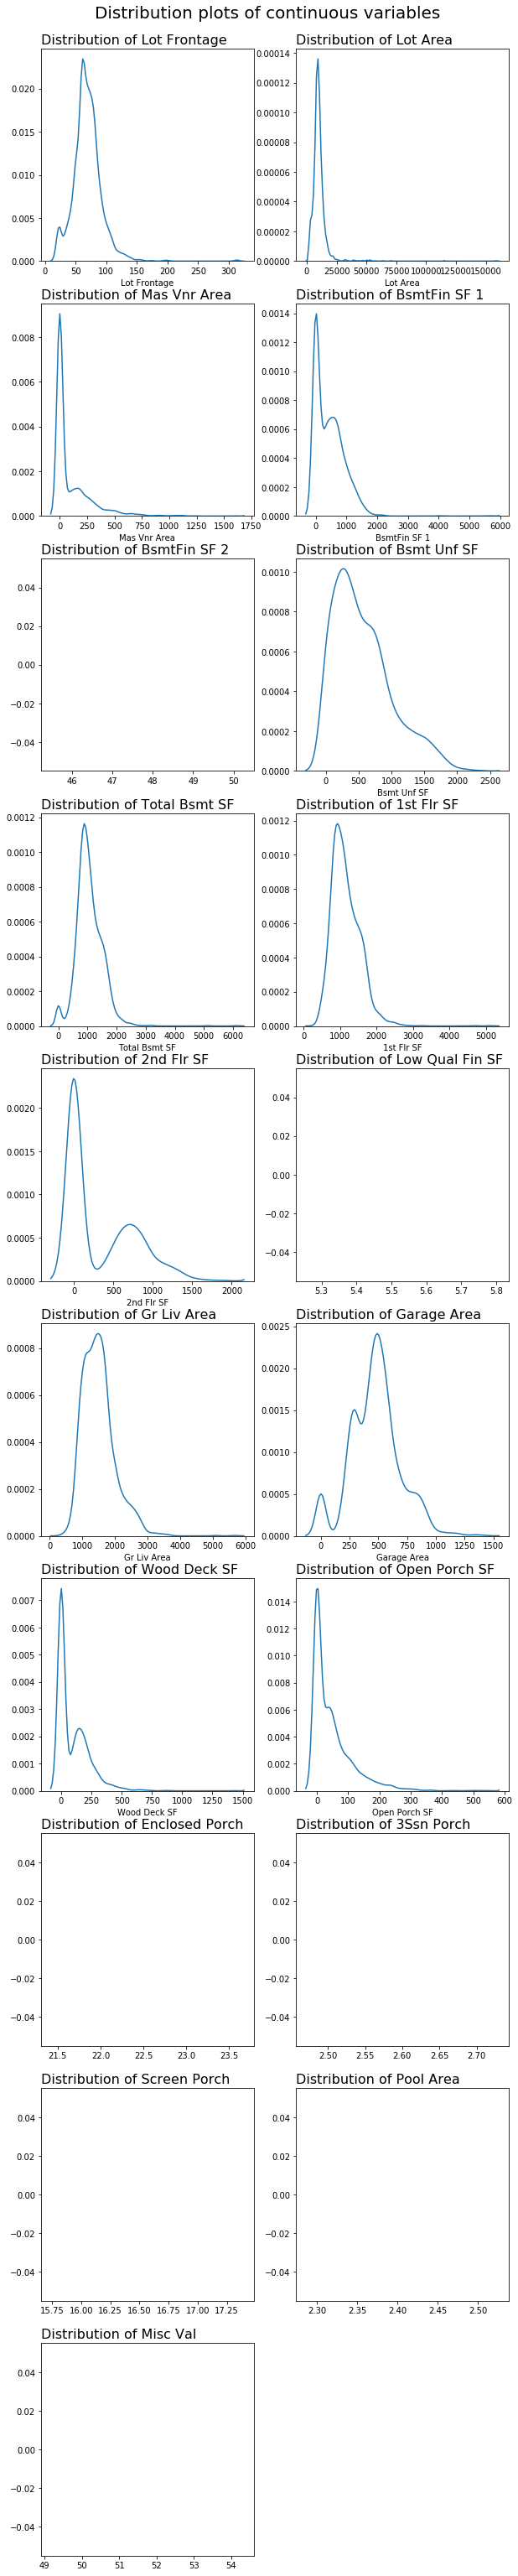

In [19]:
# Plotting distribution plots of all continuous variables.

fig, ax = plt.subplots(nrows=10, ncols=2, figsize=(10,55))

ax = ax.ravel()

for i, col in enumerate(list(continuous_corr_df.columns)):
    
    ax[i].set_title(f"Distribution of {col}", fontsize=16, loc='left')
    
    # We use try & except because some variables are not normally distributed and throw this error during kde calculation:
    # "RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density." 
    try:
        sns.distplot(ce_train[col], ax=ax[i], hist=False, kde=True)
    except:
        pass
    
ax[19].remove()

fig.suptitle(x=0.5, y=0.893, t="Distribution plots of continuous variables", fontsize=20)

# Exporting plot image in PNG format.
plt.savefig('../plot_images/distplots_continuous_variables.png', bbox_inches='tight')

From the above distribution plots, we see that **none of the continuous variables are normally distributed**. Hence, I will use the **Kendall correlation method** to determine the correlation between 'SalePrice' and continuous variables (instead of the Pearson correlation method).

In [20]:
# Finding the Kendall correlation coefficient for all continuous variable columns.

for col in continuous_corr_df.columns:
    kendall_coef = ce_train[['SalePrice', col]].corr(method='kendall').iloc[0,1]
    continuous_corr_df.loc['SalePrice', col] = kendall_coef

continuous_corr_df

Column name  Lot Frontage  Lot Area  Mas Vnr Area  BsmtFin SF 1  BsmtFin SF 2  \
SalePrice        0.281687  0.296508      0.349073      0.255441     -0.030541   

Column name  Bsmt Unf SF  Total Bsmt SF  1st Flr SF  2nd Flr SF  \
SalePrice       0.109745       0.448052    0.424598    0.185217   

Column name  Low Qual Fin SF  Gr Liv Area  Garage Area  Wood Deck SF  \
SalePrice          -0.069536     0.539097     0.488316      0.269858   

Column name  Open Porch SF  Enclosed Porch  3Ssn Porch  Screen Porch  \
SalePrice         0.357655       -0.177954    0.047482      0.085878   

Column name  Pool Area  Misc Val  
SalePrice     0.028669 -0.025752

In [21]:
# Sorting values of correlation coefficients

continuous_corr_df.sort_values(by='SalePrice', axis=1, inplace=True)
continuous_corr_df

Column name  Enclosed Porch  Low Qual Fin SF  BsmtFin SF 2  Misc Val  \
SalePrice         -0.177954        -0.069536     -0.030541 -0.025752   

Column name  Pool Area  3Ssn Porch  Screen Porch  Bsmt Unf SF  2nd Flr SF  \
SalePrice     0.028669    0.047482      0.085878     0.109745    0.185217   

Column name  BsmtFin SF 1  Wood Deck SF  Lot Frontage  Lot Area  Mas Vnr Area  \
SalePrice        0.255441      0.269858      0.281687  0.296508      0.349073   

Column name  Open Porch SF  1st Flr SF  Total Bsmt SF  Garage Area  \
SalePrice         0.357655    0.424598       0.448052     0.488316   

Column name  Gr Liv Area  
SalePrice       0.539097

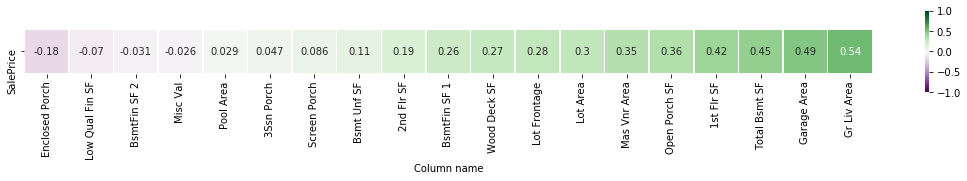

In [22]:
# Plotting the above in a heatmap to visualize the relationship.

plt.figure(figsize=(19,1.5))

sns.heatmap(continuous_corr_df, vmin=-1, vmax=1, annot=True, square=True, linewidths=0.5, cmap='PRGn')

# Exporting plot image in PNG format.
plt.savefig('../plot_images/heatmap_continuous_variables.png', bbox_inches='tight')

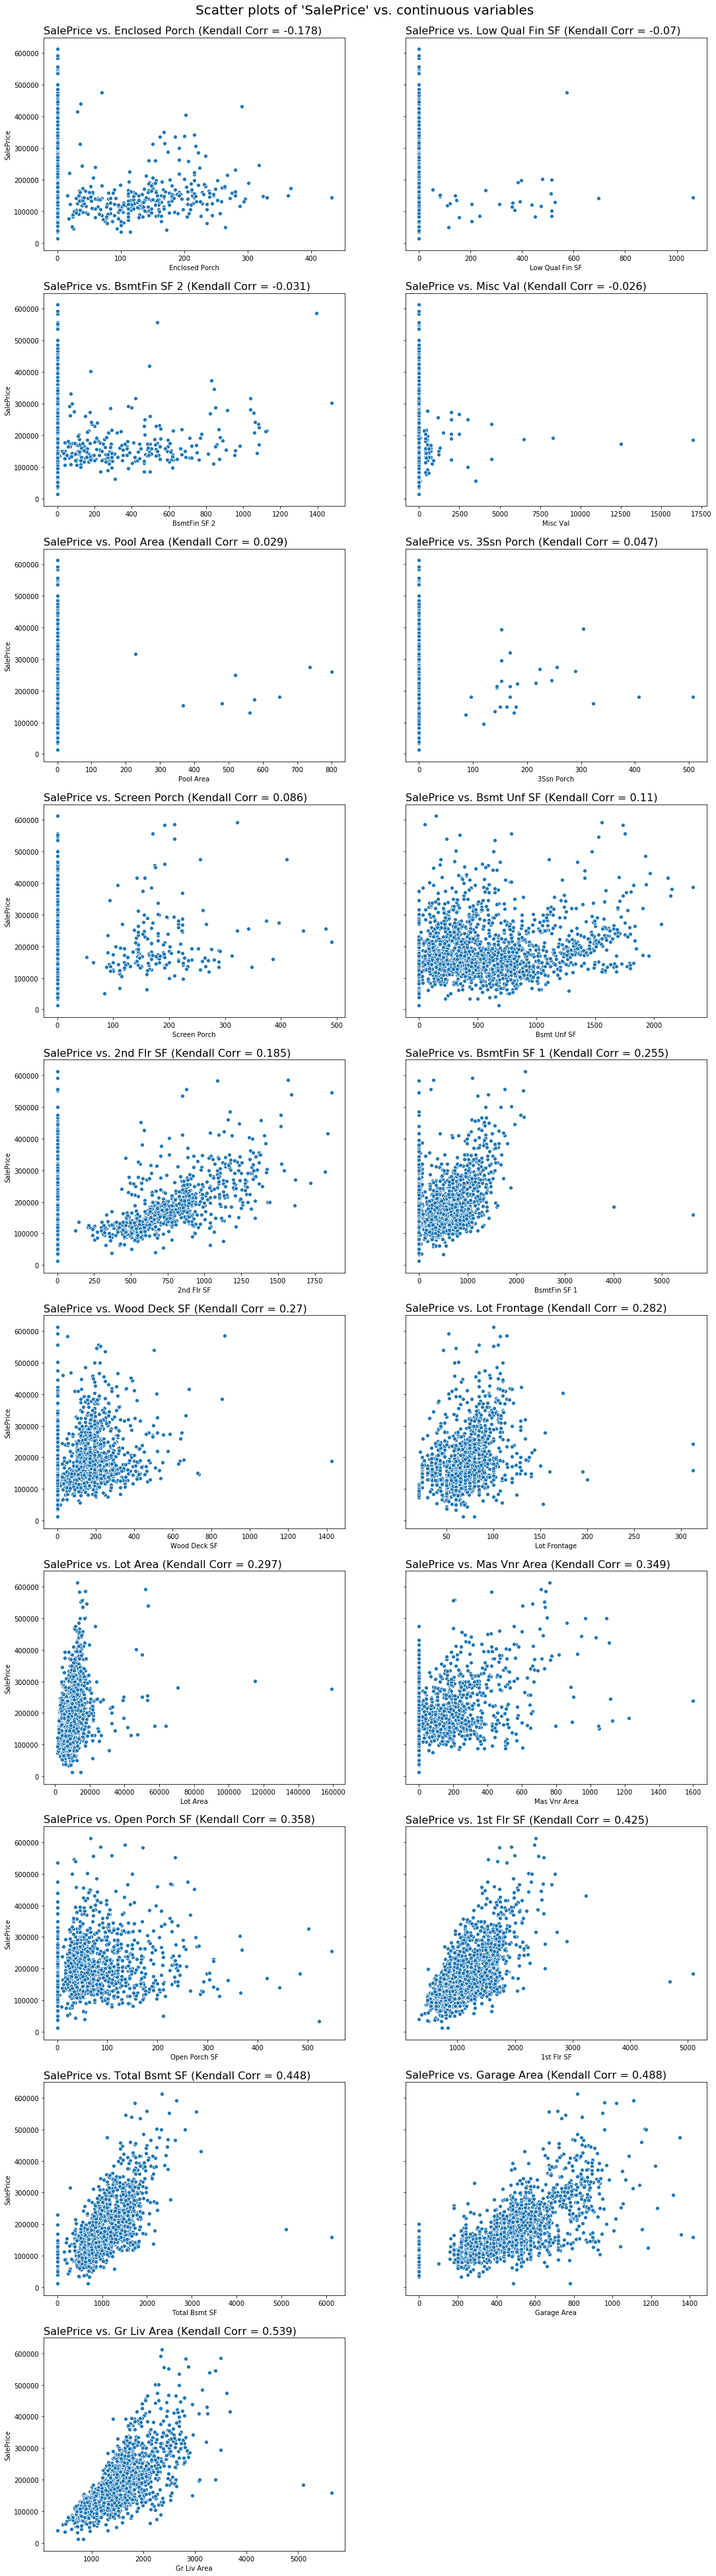

In [23]:
fig, ax = plt.subplots(nrows=10, ncols=2, figsize=(18,70), sharey=True)

ax = ax.ravel()

for i, col in enumerate(list(continuous_corr_df.columns)):
    
    sns.scatterplot(data=ce_train, x=col, y='SalePrice', ax=ax[i])
    
    kendall_coef = str(round(ce_train[['SalePrice', col]].corr(method='kendall').iloc[0,1], 3))
    
    ax[i].set_title(f"SalePrice vs. {col} (Kendall Corr = {kendall_coef})", fontsize=16, loc='left')

ax[19].remove()
fig.suptitle(x=0.5, y=0.89, t="Scatter plots of 'SalePrice' vs. continuous variables", fontsize=20)

# Exporting plot image in PNG format.
plt.savefig('../plot_images/scatterplots_continuous_variables.png', bbox_inches='tight')

From the above heatmap and scatter plots, we deduce the following about continuous variables:

- **Outliers**: Some columns, such as *'BsmtFin SF 1', 'Wood Deck SF', 'Lot Frontage', 'Lot Area', '1st Flr SF', 'Total Bsmt SF' & 'Gr Liv Area'*, have 1-2 outliers. These should be removed before proceeding, so as to ensure they have a better linear relationship with 'SalePrice', and the model built using these variables does not have a high bias.
- **Variables selected for next stage**: From the heatmap, I will select variables which have Kendall correlation coefficient of <= -0.2 & >= 0.2. So, the columns selected from this stage are: *'BsmtFin SF 1', 'Wood Deck SF', 'Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'Open Porch SF', '1st Flr SF', 'Total Bsmt SF', 'Garage Area' & 'Gr Liv Area'*.

In [24]:
# Filtering all selected variables for next stage.

continuous_selected_list = list(continuous_corr_df.T[(continuous_corr_df.T['SalePrice'] >= 0.2) | (continuous_corr_df.T['SalePrice'] <= -0.2)].index)
continuous_selected_list

['BsmtFin SF 1',
 'Wood Deck SF',
 'Lot Frontage',
 'Lot Area',
 'Mas Vnr Area',
 'Open Porch SF',
 '1st Flr SF',
 'Total Bsmt SF',
 'Garage Area',
 'Gr Liv Area']

In [25]:
# Filtering rows of outliers

# Creating masks for outliers
outlier_mask1 = ce_train['BsmtFin SF 1']>3000
outlier_mask2 = ce_train['Wood Deck SF']>1200
outlier_mask3 = ce_train['Lot Frontage']>250
outlier_mask4 = ce_train['Lot Area']>100_000
outlier_mask5 = ce_train['1st Flr SF']>4000
outlier_mask6 = ce_train['Total Bsmt SF']>4000
outlier_mask7 = ce_train['Gr Liv Area']>4000

outliers_continuous = ce_train[(outlier_mask1) | (outlier_mask2) | (outlier_mask3) | (outlier_mask4) | (outlier_mask5) | (outlier_mask6) | (outlier_mask7)]
outliers_continuous

Id          PID  Lot Frontage  Lot Area  Lot Shape  Utilities  \
471   2116.0  906426060.0           NaN  159000.0        2.0        4.0   
693   2072.0  905301050.0           NaN  115149.0        2.0        4.0   
959   1499.0  908154235.0         313.0   63887.0        1.0        4.0   
965   2294.0  923229100.0           NaN   15957.0        3.0        4.0   
1332  1266.0  535427070.0         313.0   27650.0        2.0        4.0   
1879  2181.0  908154195.0         128.0   39290.0        3.0        4.0   

      Land Slope  Overall Qual  Overall Cond  Year Built  ...  \
471          1.0           6.0           7.0      1958.0  ...   
693          1.0           7.0           5.0      1971.0  ...   
959          3.0          10.0           5.0      2008.0  ...   
965          2.0           6.0           6.0      1977.0  ...   
1332         2.0           7.0           7.0      1960.0  ...   
1879         3.0          10.0           5.0      2008.0  ...   

      Misc Feature_Shed  Misc Feature_TenC  Sale Type_CWD  Sale Type_Con  \
471                   1                  0              0              0   
693                   0                  0              0              0   
959                   0                  0              0              0   
965                   0                  0              0              0   
1332                  0                  0              0              0   
1879                  0                  0              0              0   

      Sale Type_ConLD  Sale Type_ConLI  Sale Type_ConLw  Sale Type_New  \
471                 0                0                0              0   
693                 0                0                0              0   
959                 0                0                0              1   
965                 0                0                0              0   
1332                0                0                0              0   
1879                0                0                0              1   

      Sale Type_Oth  Sale Type_WD   
471               0              1  
693               0              1  
959               0              0  
965               0              1  
1332              0              1  
1879              0              0  

[6 rows x 213 columns]

In [26]:
# Dropping the above 6 rows of outliers from ce_train dataframe.

ce_train.drop(index=outliers_continuous.index, inplace=True)
ce_train.shape

(2038, 213)

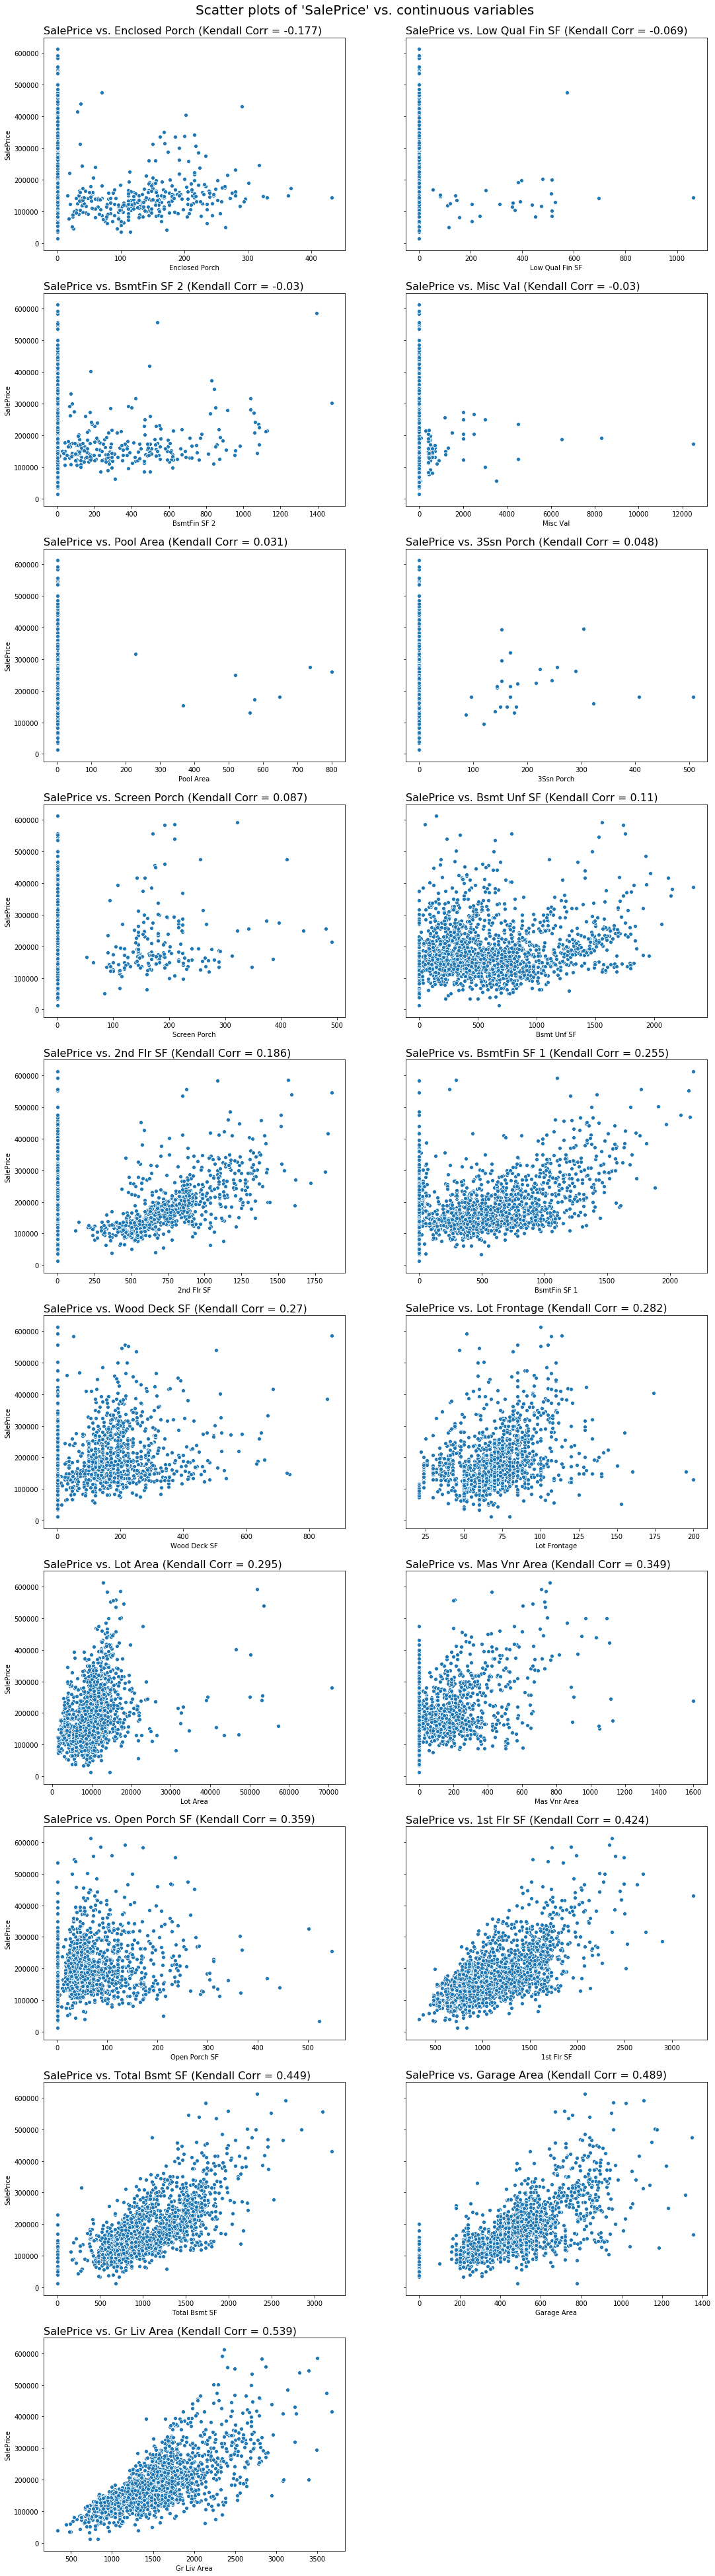

In [27]:
# Plotting the scatter plots again.

fig, ax = plt.subplots(nrows=10, ncols=2, figsize=(18,70), sharey=True)

ax = ax.ravel()

for i, col in enumerate(list(continuous_corr_df.columns)):
    
    sns.scatterplot(data=ce_train, x=col, y='SalePrice', ax=ax[i])
    
    kendall_coef = str(round(ce_train[['SalePrice', col]].corr(method='kendall').iloc[0,1], 3))
    
    ax[i].set_title(f"SalePrice vs. {col} (Kendall Corr = {kendall_coef})", fontsize=16, loc='left')

ax[19].remove()
fig.suptitle(x=0.5, y=0.89, t="Scatter plots of 'SalePrice' vs. continuous variables", fontsize=20)

# Exporting plot image in PNG format.
plt.savefig('../plot_images/scatterplots_continuous_variables_wo_outliers.png', bbox_inches='tight')

### EDA for Discrete Variables

In [28]:
# Filtering all columns of discrete variables.
# These columns will be used to calculate the correlation coefficient against 'SalePrice' column.

discrete_corr_df = pd.DataFrame(data_dict.loc[data_dict['Variable type']=='discrete', 'Column name'])

#Creating an extra column 'SalePrice' of 0 values. These values will be replaced with the correlation coefficient.
discrete_corr_df['SalePrice'] = 0

# Setting 'Column name' column as index.
discrete_corr_df.set_index('Column name', inplace=True)

# Transposing the dataframe to make indices into columns.
discrete_corr_df = discrete_corr_df.T

# Dropping the 'Id' column (As explained above, 'Id' column shows observation number. So, it wouldn't make logical sense to include it in the regression model.)
discrete_corr_df.drop(columns=['Id'], inplace=True)

discrete_corr_df

Column name  Year Built  Year Remod/Add  Bsmt Full Bath  Bsmt Half Bath  \
SalePrice             0               0               0               0   

Column name  Full Bath  Half Bath  Bedroom AbvGr  Kitchen AbvGr  \
SalePrice            0          0              0              0   

Column name  TotRms AbvGrd  Fireplaces  Garage Yr Blt  Garage Cars  Mo Sold  \
SalePrice                0           0              0            0        0   

Column name  Yr Sold  
SalePrice          0

Similar to continuous variables above, to determine which correlation method should be used for discrete variables, I will have to first determine the distribution of each variable itself. According to this [page](https://www.statisticssolutions.com/correlation-pearson-kendall-spearman/), one of the assumptions for Pearson correlation is that the variables should be normally distributed. So, if the discrete variable is normally distributed, Pearson correlation will be used. If it is not normally distributed, Kendall correlation will be utilized. According to this [page](https://towardsdatascience.com/kendall-rank-correlation-explained-dee01d99c535), "*Kendall rank correlation (non-parametric) is an alternative to Pearson’s correlation (parametric) when the data you’re working with has failed one or more assumptions of the test*."

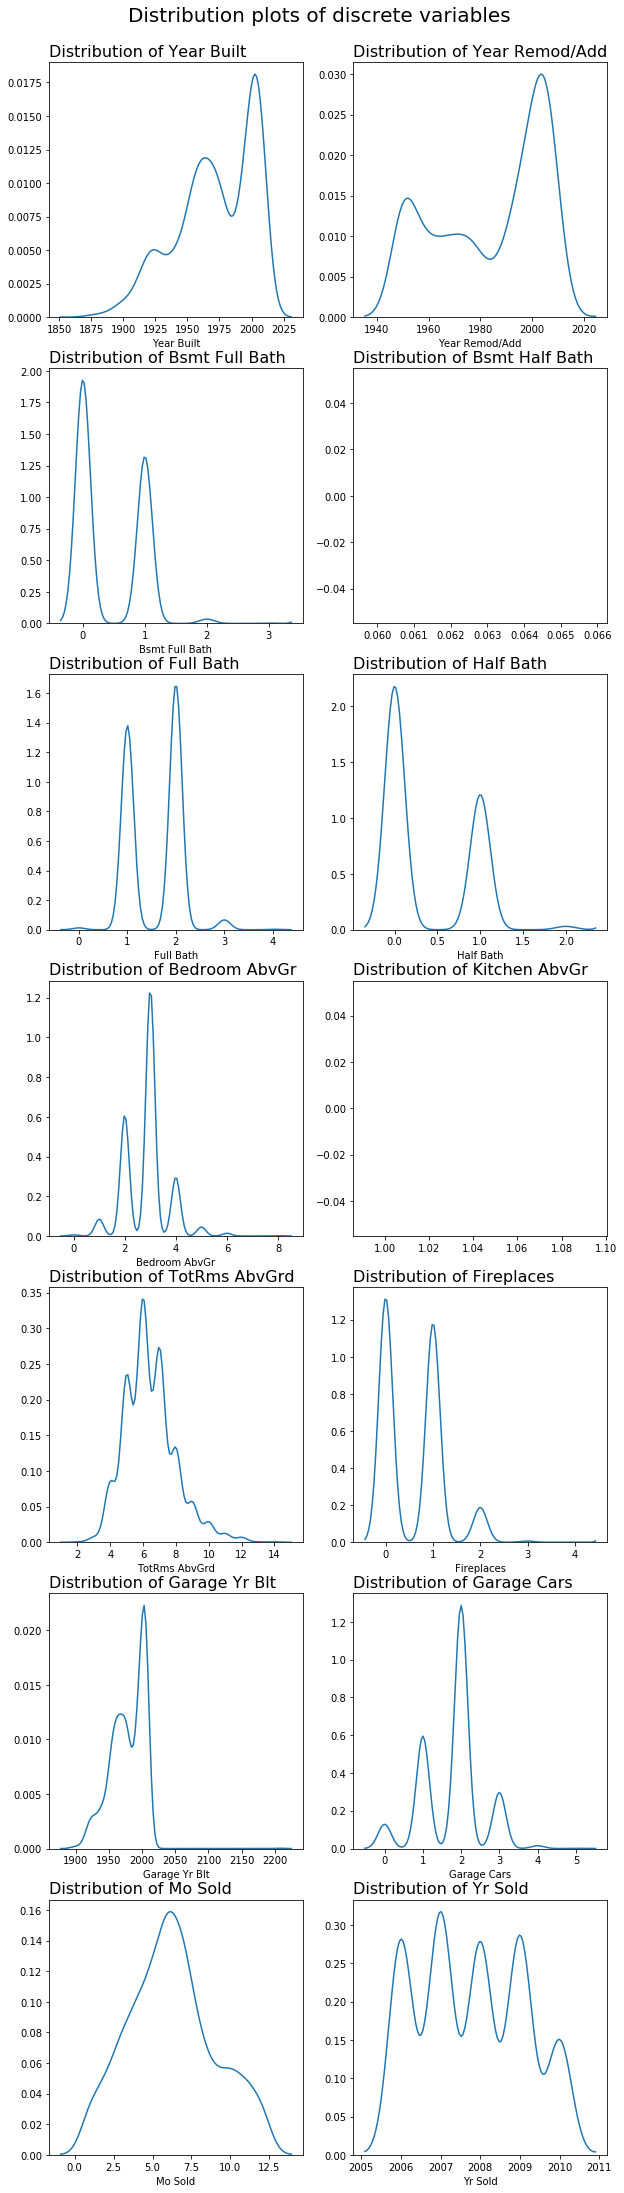

In [29]:
# Plotting distribution plots of all discrete & ordinal variables.

fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(10,38.5))

ax = ax.ravel()

for i, col in enumerate(list(discrete_corr_df.columns)):
    
    ax[i].set_title(f"Distribution of {col}", fontsize=16, loc='left')
    
    # We use try & except because some variables are not normally distributed and throw this error during kde calculation:
    # "RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density." 
    try:
        sns.distplot(ce_train[col], ax=ax[i], hist=False, kde=True)
    except:
        pass

fig.suptitle(x=0.5, y=0.9, t="Distribution plots of discrete variables", fontsize=20)

# Exporting plot image in PNG format.
plt.savefig('../plot_images/distplots_discrete_variables.png', bbox_inches='tight')

From the above distribution plots, we see that **none of the discrete variables are normally distributed**. Hence, I will use the **Kendall correlation method** to determine the correlation between 'SalePrice' and discrete variables (instead of the Pearson correlation method).

In [30]:
# Finding the Kendall correlation coefficient for all discrete variable columns.

for col in discrete_corr_df.columns:
    kendall_coef = ce_train[['SalePrice', col]].corr(method='kendall').iloc[0,1]
    discrete_corr_df.loc['SalePrice', col] = kendall_coef

discrete_corr_df

Column name  Year Built  Year Remod/Add  Bsmt Full Bath  Bsmt Half Bath  \
SalePrice      0.500042        0.447749         0.22223       -0.028739   

Column name  Full Bath  Half Bath  Bedroom AbvGr  Kitchen AbvGr  \
SalePrice     0.508206   0.268814        0.14783      -0.122376   

Column name  TotRms AbvGrd  Fireplaces  Garage Yr Blt  Garage Cars   Mo Sold  \
SalePrice         0.388082    0.417436       0.457047     0.578326  0.027837   

Column name   Yr Sold  
SalePrice   -0.005988

In [31]:
# Sorting values of correlation coefficients

discrete_corr_df.sort_values(by='SalePrice', axis=1, inplace=True)
discrete_corr_df

Column name  Kitchen AbvGr  Bsmt Half Bath   Yr Sold   Mo Sold  Bedroom AbvGr  \
SalePrice        -0.122376       -0.028739 -0.005988  0.027837        0.14783   

Column name  Bsmt Full Bath  Half Bath  TotRms AbvGrd  Fireplaces  \
SalePrice           0.22223   0.268814       0.388082    0.417436   

Column name  Year Remod/Add  Garage Yr Blt  Year Built  Full Bath  Garage Cars  
SalePrice          0.447749       0.457047    0.500042   0.508206     0.578326

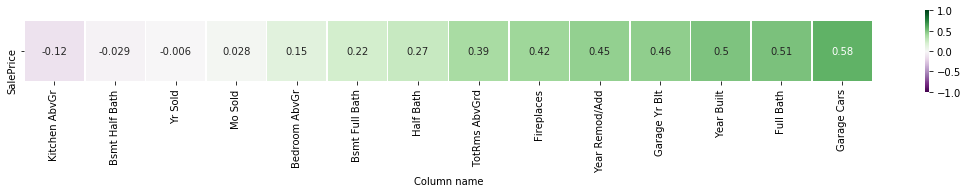

In [32]:
# Plotting the above in a heatmap to visualize the relationship.

plt.figure(figsize=(19,1.5))

sns.heatmap(discrete_corr_df, vmin=-1, vmax=1, annot=True, square=True, linewidths=0.5, cmap='PRGn')

# Exporting plot image in PNG format.
plt.savefig('../plot_images/heatmap_discrete_variables.png', bbox_inches='tight')

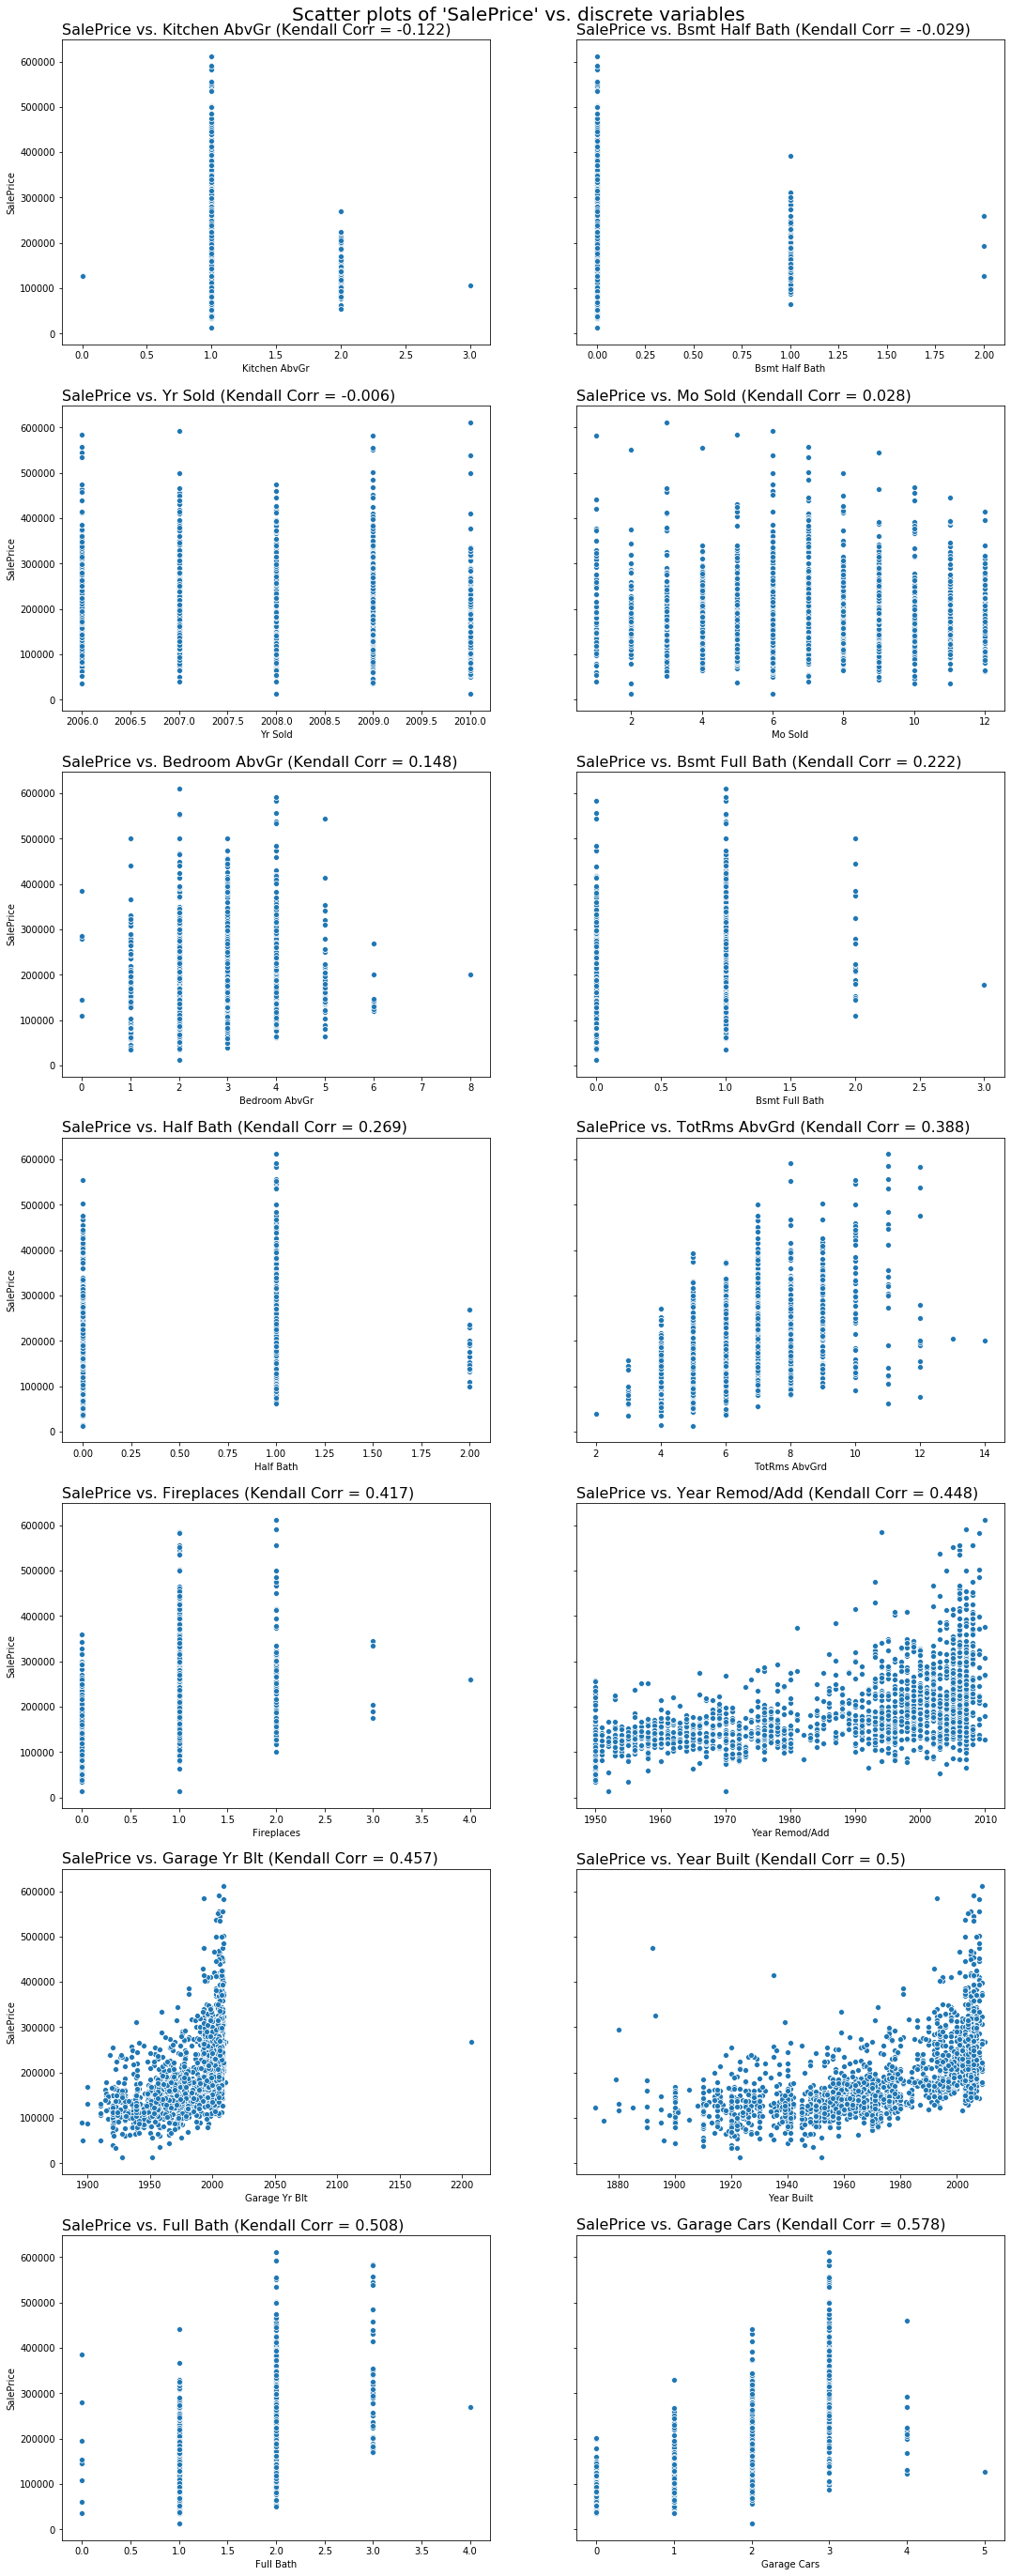

In [33]:
fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(18,49), sharey=True)

ax = ax.ravel()

for i, col in enumerate(list(discrete_corr_df.columns)):
    
    sns.scatterplot(data=ce_train, x=col, y='SalePrice', ax=ax[i])
    
    kendall_coef = str(round(ce_train[['SalePrice', col]].corr(method='kendall').iloc[0,1], 3))
    
    ax[i].set_title(f"SalePrice vs. {col} (Kendall Corr = {kendall_coef})", fontsize=16, loc='left')

fig.suptitle(x=0.5, y=0.89, t="Scatter plots of 'SalePrice' vs. discrete variables", fontsize=20)

# Exporting plot image in PNG format.
plt.savefig('../plot_images/scatterplots_discrete_variables.png', bbox_inches='tight')

From the above heatmap and scatter plots, we deduce the following about discrete variables:

- **Outliers**: *'Garage Yr Blt'* has an outlier, which is clearly wrong (year built cannot be more than 2020). This outlier should be removed before proceeding.
- **Variables selected for next stage**: From the heatmap, I will select variables which have Kendall correlation coefficient of <= -0.2 & >= 0.2. So, the columns selected from this stage are: *'Bsmt Full Bath', 'Half Bath', 'TotRms AbvGrd', 'Fireplaces', 'Year Remod/Add', 'Garage Yr Blt', 'Year Built', 'Full Bath', & 'Garage Cars'*.

In [34]:
# Filtering all selected variables for next stage.

discrete_selected_list = list(discrete_corr_df.T[(discrete_corr_df.T['SalePrice'] >= 0.2) | (discrete_corr_df.T['SalePrice'] <= -0.2)].index)
discrete_selected_list

['Bsmt Full Bath',
 'Half Bath',
 'TotRms AbvGrd',
 'Fireplaces',
 'Year Remod/Add',
 'Garage Yr Blt',
 'Year Built',
 'Full Bath',
 'Garage Cars']

In [35]:
# Filtering rows of outliers

# Creating masks for outliers
outlier_mask1 = ce_train['Garage Yr Blt']>2020

outliers_discrete = ce_train[(outlier_mask1)]
outliers_discrete

Id          PID  Lot Frontage  Lot Area  Lot Shape  Utilities  \
1694  2261.0  916384070.0          68.0    8298.0        3.0        4.0   

      Land Slope  Overall Qual  Overall Cond  Year Built  ...  \
1694         3.0           8.0           5.0      2006.0  ...   

      Misc Feature_Shed  Misc Feature_TenC  Sale Type_CWD  Sale Type_Con  \
1694                  0                  0              0              0   

      Sale Type_ConLD  Sale Type_ConLI  Sale Type_ConLw  Sale Type_New  \
1694                0                0                0              1   

      Sale Type_Oth  Sale Type_WD   
1694              0              0  

[1 rows x 213 columns]

In [36]:
# Dropping the above row of outlier from ce_train dataframe.

ce_train.drop(index=outliers_discrete.index, inplace=True)
ce_train.shape

(2037, 213)

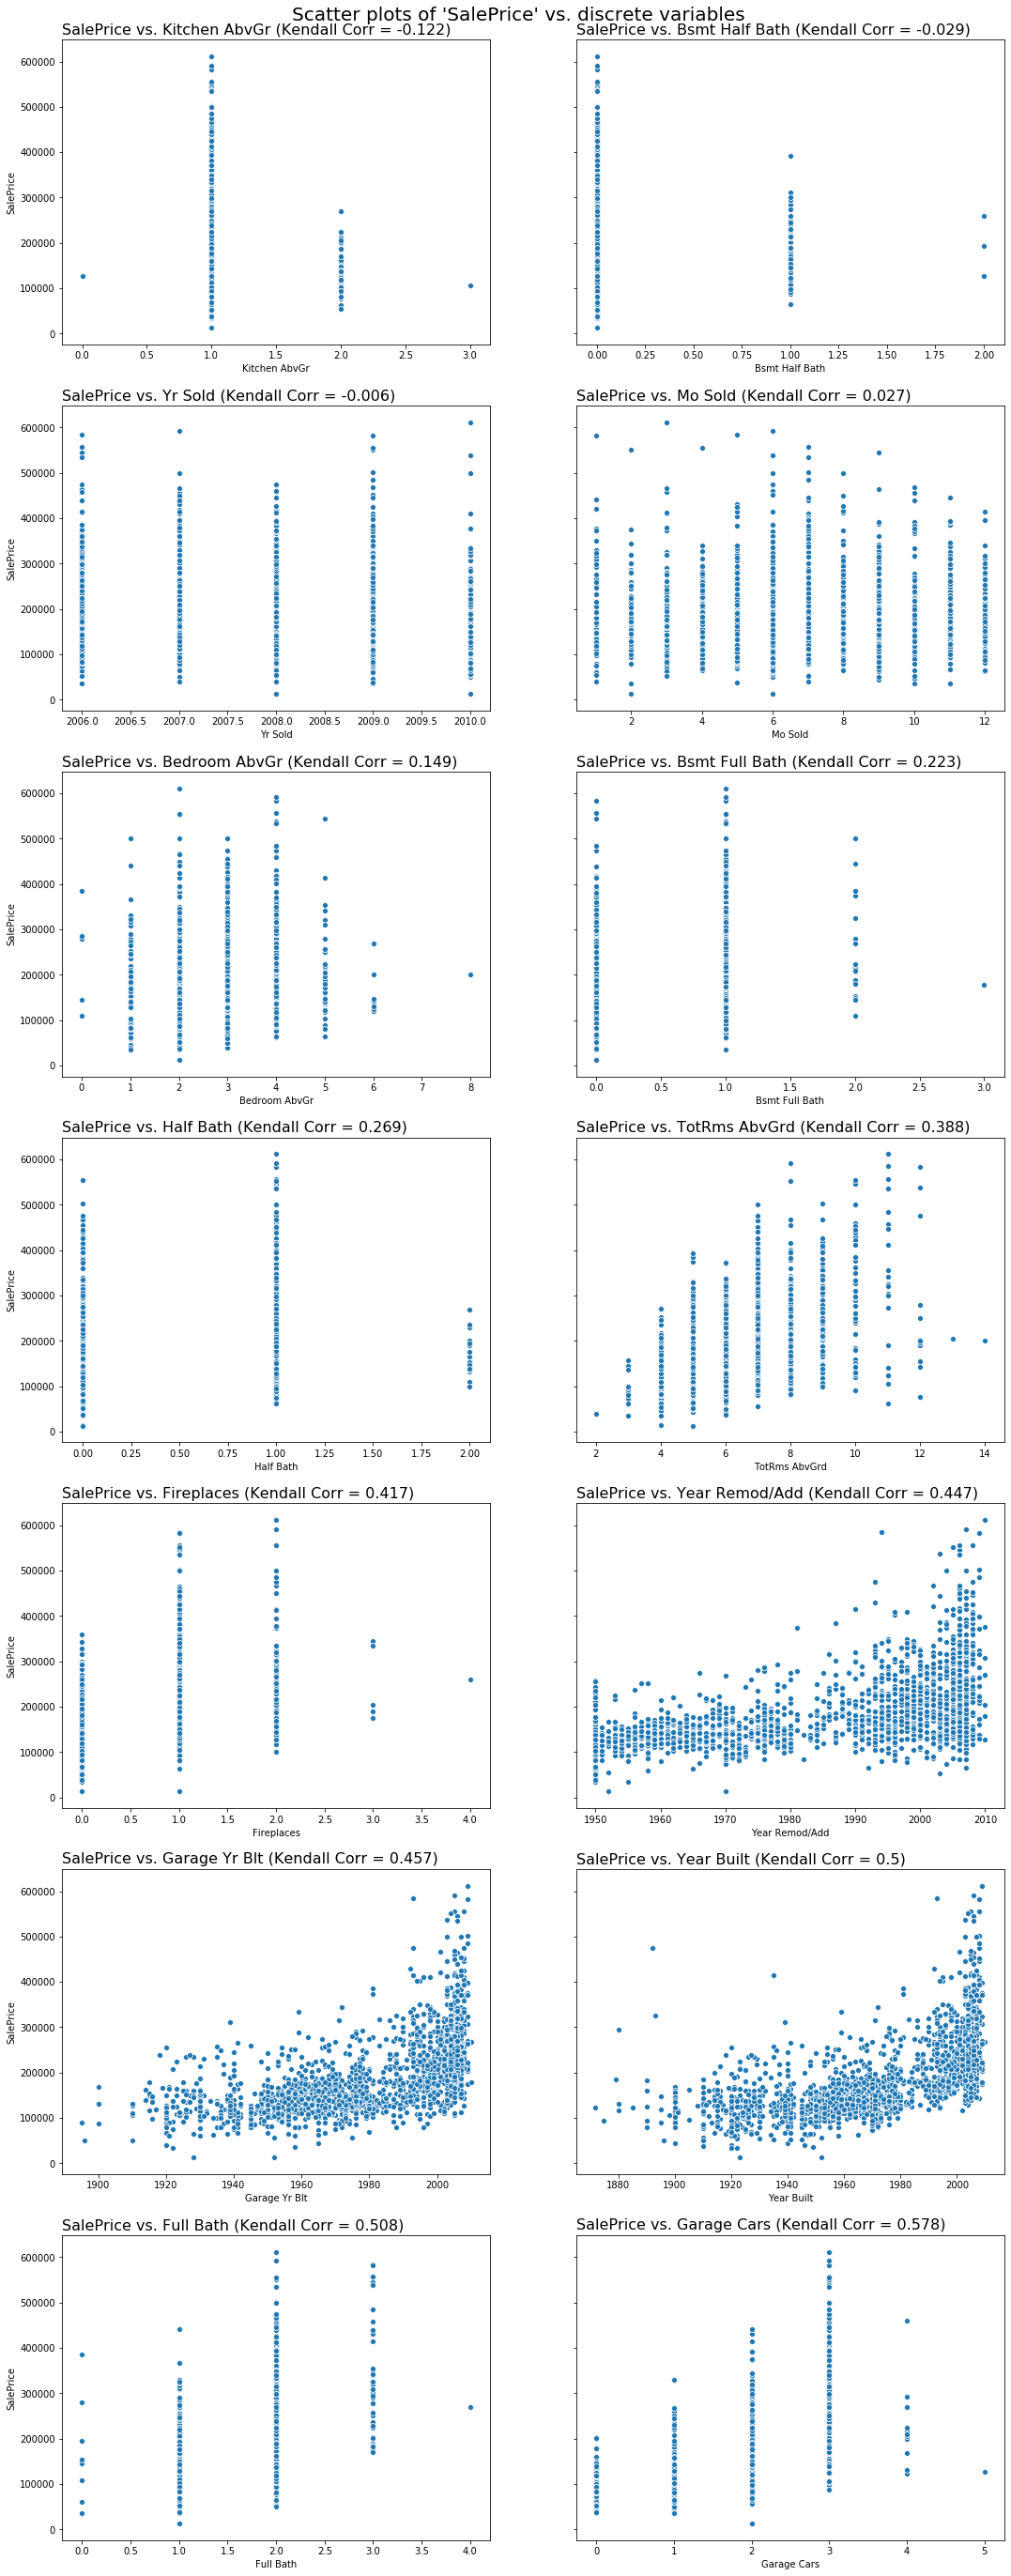

In [37]:
fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(18,49), sharey=True)

ax = ax.ravel()

for i, col in enumerate(list(discrete_corr_df.columns)):
    
    sns.scatterplot(data=ce_train, x=col, y='SalePrice', ax=ax[i])
    
    kendall_coef = str(round(ce_train[['SalePrice', col]].corr(method='kendall').iloc[0,1], 3))
    
    ax[i].set_title(f"SalePrice vs. {col} (Kendall Corr = {kendall_coef})", fontsize=16, loc='left')

fig.suptitle(x=0.5, y=0.89, t="Scatter plots of 'SalePrice' vs. discrete variables", fontsize=20)

# Exporting plot image in PNG format.
plt.savefig('../plot_images/scatterplots_discrete_variables_wo_outliers.png', bbox_inches='tight')

### EDA for Ordinal Variables

In [38]:
# Filtering all columns of ordinal variables.
# These columns will be used to calculate the correlation coefficient against 'SalePrice' column.

ordinal_corr_df = pd.DataFrame(data_dict.loc[data_dict['Variable type']=='ordinal', 'Column name'])

#Creating an extra column 'SalePrice' of 0 values. These values will be replaced with the correlation coefficient.
ordinal_corr_df['SalePrice'] = 0

# Setting 'Column name' column as index.
ordinal_corr_df.set_index('Column name', inplace=True)

# Transposing the dataframe to make indices into columns.
ordinal_corr_df = ordinal_corr_df.T

ordinal_corr_df

Column name  Lot Shape  Utilities  Land Slope  Overall Qual  Overall Cond  \
SalePrice            0          0           0             0             0   

Column name  Exter Qual  Exter Cond  Bsmt Qual  Bsmt Cond  Bsmt Exposure  ...  \
SalePrice             0           0          0          0              0  ...   

Column name  Electrical  Kitchen Qual  Functional  Fireplace Qu  \
SalePrice             0             0           0             0   

Column name  Garage Finish  Garage Qual  Garage Cond  Paved Drive  Pool QC  \
SalePrice                0            0            0            0        0   

Column name  Fence  
SalePrice        0  

[1 rows x 23 columns]

According to this [page](https://www.statisticssolutions.com/correlation-pearson-kendall-spearman/), Spearman rank correlation should be used when the variables are measured on an ordinal scale. So, I will use the **Spearman correlation method** to determine the correlation between 'SalePrice' and ordinal variables (instead of the Pearson or Kendall correlation method).

In [39]:
# Finding the Spearman correlation coefficient for all discrete variable columns.

for col in ordinal_corr_df.columns:
    spearman_coef = ce_train[['SalePrice', col]].corr(method='spearman').iloc[0,1]
    ordinal_corr_df.loc['SalePrice', col] = spearman_coef

ordinal_corr_df

Column name  Lot Shape  Utilities  Land Slope  Overall Qual  Overall Cond  \
SalePrice    -0.360464   0.036605   -0.045598      0.809084     -0.160724   

Column name  Exter Qual  Exter Cond  Bsmt Qual  Bsmt Cond  Bsmt Exposure  ...  \
SalePrice      0.699024    0.031576   0.699877   0.282075       0.386144  ...   

Column name  Electrical  Kitchen Qual  Functional  Fireplace Qu  \
SalePrice      0.307633      0.683706    0.128762       0.54155   

Column name  Garage Finish  Garage Qual  Garage Cond  Paved Drive   Pool QC  \
SalePrice         0.637666      0.36933     0.341743     0.350623  0.037785   

Column name     Fence  
SalePrice   -0.184658  

[1 rows x 23 columns]

In [40]:
# Sorting values of correlation coefficients

ordinal_corr_df.sort_values(by='SalePrice', axis=1, inplace=True)
ordinal_corr_df

Column name  Lot Shape     Fence  Overall Cond  Land Slope  Exter Cond  \
SalePrice    -0.360464 -0.184658     -0.160724   -0.045598    0.031576   

Column name  Utilities   Pool QC  BsmtFin Type 2  Functional  Bsmt Cond  ...  \
SalePrice     0.036605  0.037785        0.044873    0.128762   0.282075  ...   

Column name  Garage Qual  Bsmt Exposure  BsmtFin Type 1  Heating QC  \
SalePrice        0.36933       0.386144        0.415195    0.520904   

Column name  Fireplace Qu  Garage Finish  Kitchen Qual  Exter Qual  Bsmt Qual  \
SalePrice         0.54155       0.637666      0.683706    0.699024   0.699877   

Column name  Overall Qual  
SalePrice        0.809084  

[1 rows x 23 columns]

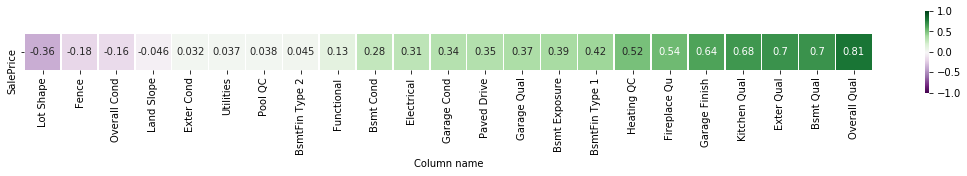

In [41]:
# Plotting the above in a heatmap to visualize the relationship.

plt.figure(figsize=(19,1.5))

sns.heatmap(ordinal_corr_df, vmin=-1, vmax=1, annot=True, square=True, linewidths=0.5, cmap='PRGn')

# Exporting plot image in PNG format.
plt.savefig('../plot_images/heatmap_ordinal_variables.png', bbox_inches='tight')

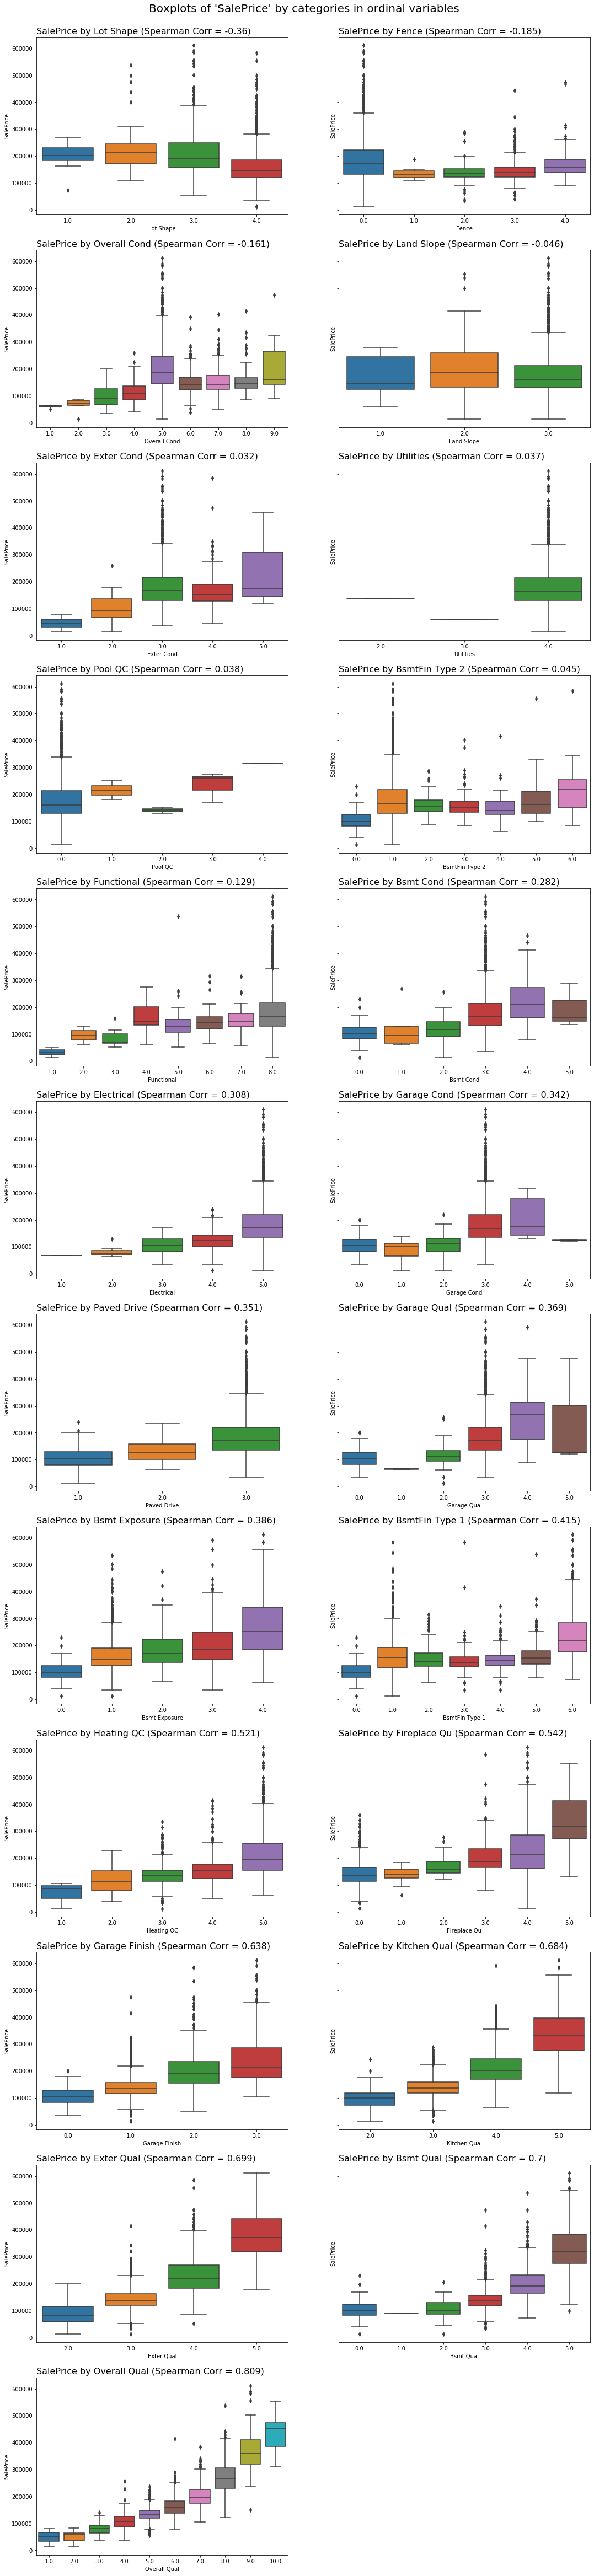

In [42]:
fig, ax = plt.subplots(nrows=12, ncols=2, figsize=(18,84), sharey=True)

ax = ax.ravel()

for i, col in enumerate(list(ordinal_corr_df.columns)):
    
    sns.boxplot(data=ce_train, x=col, y='SalePrice', ax=ax[i])
    
    spearman_coef = str(round(ce_train[['SalePrice', col]].corr(method='spearman').iloc[0,1], 3))
    
    ax[i].set_title(f"SalePrice by {col} (Spearman Corr = {spearman_coef})", fontsize=16, loc='left')

ax[23].remove()
    
fig.suptitle(x=0.5, y=0.89, t="Boxplots of 'SalePrice' by categories in ordinal variables", fontsize=20)

# Exporting plot image in PNG format.
plt.savefig('../plot_images/boxplots_ordinal_variables.png', bbox_inches='tight')

From the above heatmap and scatter plots, we deduce the following about ordinal categorical variables:

- **Outliers**: There seems to be a presence of multiple points outside the whisker ranges in all of the boxplots above (*whis=1.5* by default). However, these points should not be termed as outliers directly, as there are a large number of such points (which means they represent the nature of the data spread in some way). So, these points do not need to be removed before proceeding.
- **Variables selected for next stage**: From the heatmap, I will select variables which have Spearman correlation coefficient of <= -0.2 & >= 0.2. So, the columns selected from this stage are: *'Lot Shape', 'Bsmt Cond', 'Electrical', 'Garage Cond', 'Paved Drive', 'Garage Qual', 'Bsmt Exposure', 'BsmtFin Type 1', 'Heating QC', 'Fireplace Qu', 'Garage Finish', 'Kitchen Qual', 'Exter Qual', 'Bsmt Qual' & 'Overall Qual'*.

In [43]:
# Filtering all selected variables for next stage.

ordinal_selected_list = list(ordinal_corr_df.T[(ordinal_corr_df.T['SalePrice'] >= 0.2) | (ordinal_corr_df.T['SalePrice'] <= -0.2)].index)
ordinal_selected_list

['Lot Shape',
 'Bsmt Cond',
 'Electrical',
 'Garage Cond',
 'Paved Drive',
 'Garage Qual',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'Heating QC',
 'Fireplace Qu',
 'Garage Finish',
 'Kitchen Qual',
 'Exter Qual',
 'Bsmt Qual',
 'Overall Qual']

### EDA for Nominal Variables

## EDIT THIS AGAIN

According to this [page](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9) and this [page](https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792), Pearson's R statistic calculation method (used in *df.corr()* method) is not the best correlation coefficient for categorical variables, esp. for nominal ones. Also, even though all nominal columns in the above dataframe have been one-hot encoded, we see that the number of columns in the above dataframe is >200, which is too large to be plotted in a heatmap directly. So, we will instead use Cramer's V coefficient to calculate the relationship between nominal variables, and the target variable 'SalePrice'. The code for Cramer's V has been taken from this [page](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9).

In [44]:
# Filtering all columns of nominal variables.
# These columns will be used to calculate the correlation coefficient against 'SalePrice' column.

nominal_cols_list = list(data_dict.loc[data_dict['Variable type']=='nominal', 'Column name'])
nominal_cols_list

# Dropping the 'PID' column (As explained above, 'PID' column shows parcel identification number. So, it wouldn't make logical sense to include it in the regression model.)
nominal_cols_list.remove('PID')
nominal_cols_list

['MS SubClass',
 'MS Zoning',
 'Street',
 'Alley',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Mas Vnr Type',
 'Foundation',
 'Heating',
 'Central Air',
 'Garage Type',
 'Misc Feature',
 'Sale Type']

In [45]:
# Creating a dictionary with keys as column names from the list nominal_cols_list,
# and values as a dataframe of all one-hot encoded categories of that particular column.

nominal_cols_dict = {}

for col in nominal_cols_list:
    one_hot_list = [_ for _ in ce_train.columns if col in _]
    
    # Taking care to remove 'Heating QC' column from being incorrectly detected as a one-hot encoded category for the 'Heating' column by the above line of code.
    if col=='Heating':
        one_hot_list.remove('Heating QC')
    
    nominal_cols_dict[col] = pd.DataFrame(data=0, columns=one_hot_list, index=['SalePrice'])

In [46]:
# From above, I obtain a dictionary with keys as all nominal columns and values as individual dataframes of all the one-hot encoded columns.
# For instance, for 'Bldg Type' nominal variable, I have:

nominal_cols_dict['Bldg Type']

Bldg Type_2fmCon  Bldg Type_Duplex  Bldg Type_Twnhs  \
SalePrice                 0                 0                0   

           Bldg Type_TwnhsE  
SalePrice                 0

## EDIT THIS TO SAY THAT KENDALL IS GOOD FOR NOMINAL VARIABLES

According to this [page](https://www.statisticssolutions.com/correlation-pearson-kendall-spearman/), Spearman rank correlation should be used when the variables are measured on an ordinal scale. So, I will use the **Spearman correlation method** to determine the correlation between 'SalePrice' and ordinal variables (instead of the Pearson or Kendall correlation method).

In [47]:
# Finding the Kendall correlation coefficient for all nominal variable columns.

for col, df in nominal_cols_dict.items():
    for df_col in df.columns:
        kendall_coef = ce_train[['SalePrice', df_col]].corr(method='kendall').iloc[0,1]
        df.loc['SalePrice', df_col] = kendall_coef
    
    # Sorting values of correlation coefficients
    df.sort_values(by='SalePrice', axis=1, inplace=True)

In [48]:
# After running the code in above cell, we have:

nominal_cols_dict['Bldg Type']

Bldg Type_2fmCon  Bldg Type_Twnhs  Bldg Type_Duplex  \
SalePrice         -0.114522        -0.105182         -0.096811   

           Bldg Type_TwnhsE  
SalePrice          0.084711

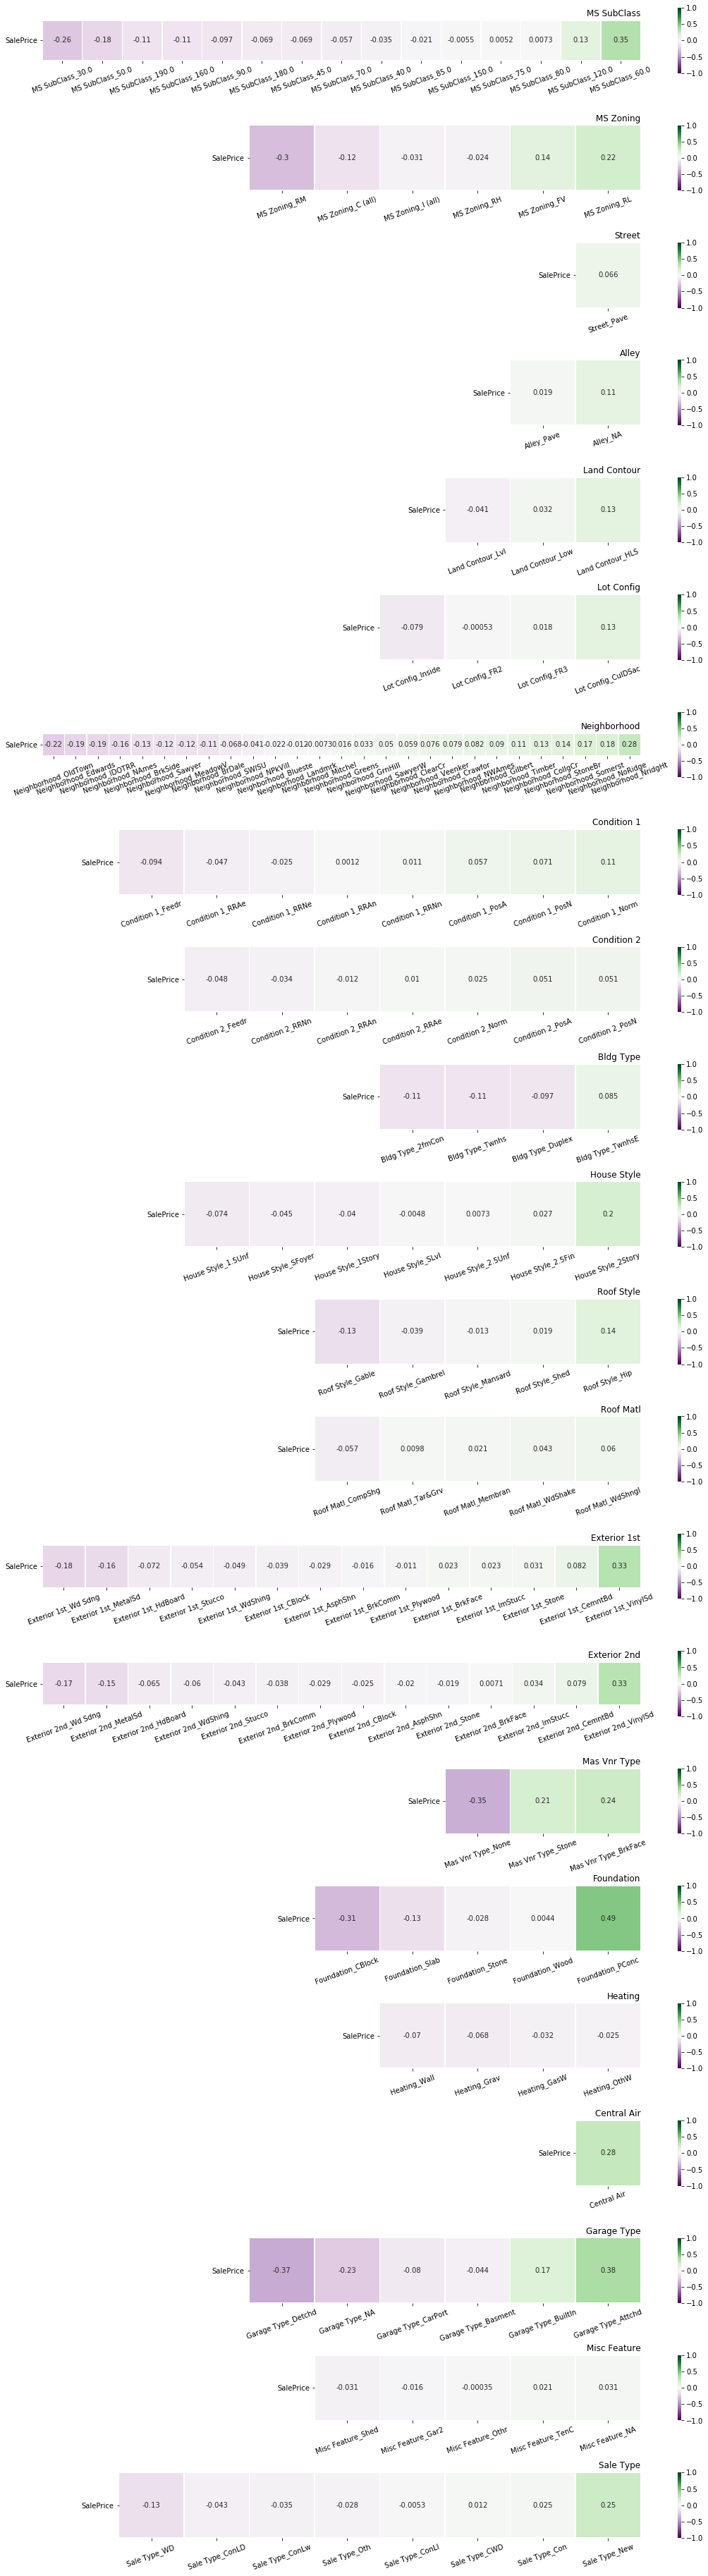

In [49]:
# Plotting the above in a heatmap subplots to visualize the relationships.

fig, ax = plt.subplots(nrows=22, ncols=1, figsize=(19,66))

ax = ax.ravel()

for i, col in enumerate(nominal_cols_dict):

    sns.heatmap(nominal_cols_dict[col], vmin=-1, vmax=1, annot=True, ax=ax[i], square=True, linewidths=0.5, cmap='PRGn')
    
    # Setting the title and x- and y-axis label rotation.
    ax[i].set_title(col, loc='right')
    ax[i].tick_params(axis='x', labelrotation=20)
    ax[i].tick_params(axis='y', labelrotation=0)

# Adjusting the horizontal space between subplots to make the figure more clear.
plt.subplots_adjust(hspace=0.8)
    
# Exporting plot image in PNG format.
plt.savefig('../plot_images/heatmap_nominal_variables.png', bbox_inches='tight')

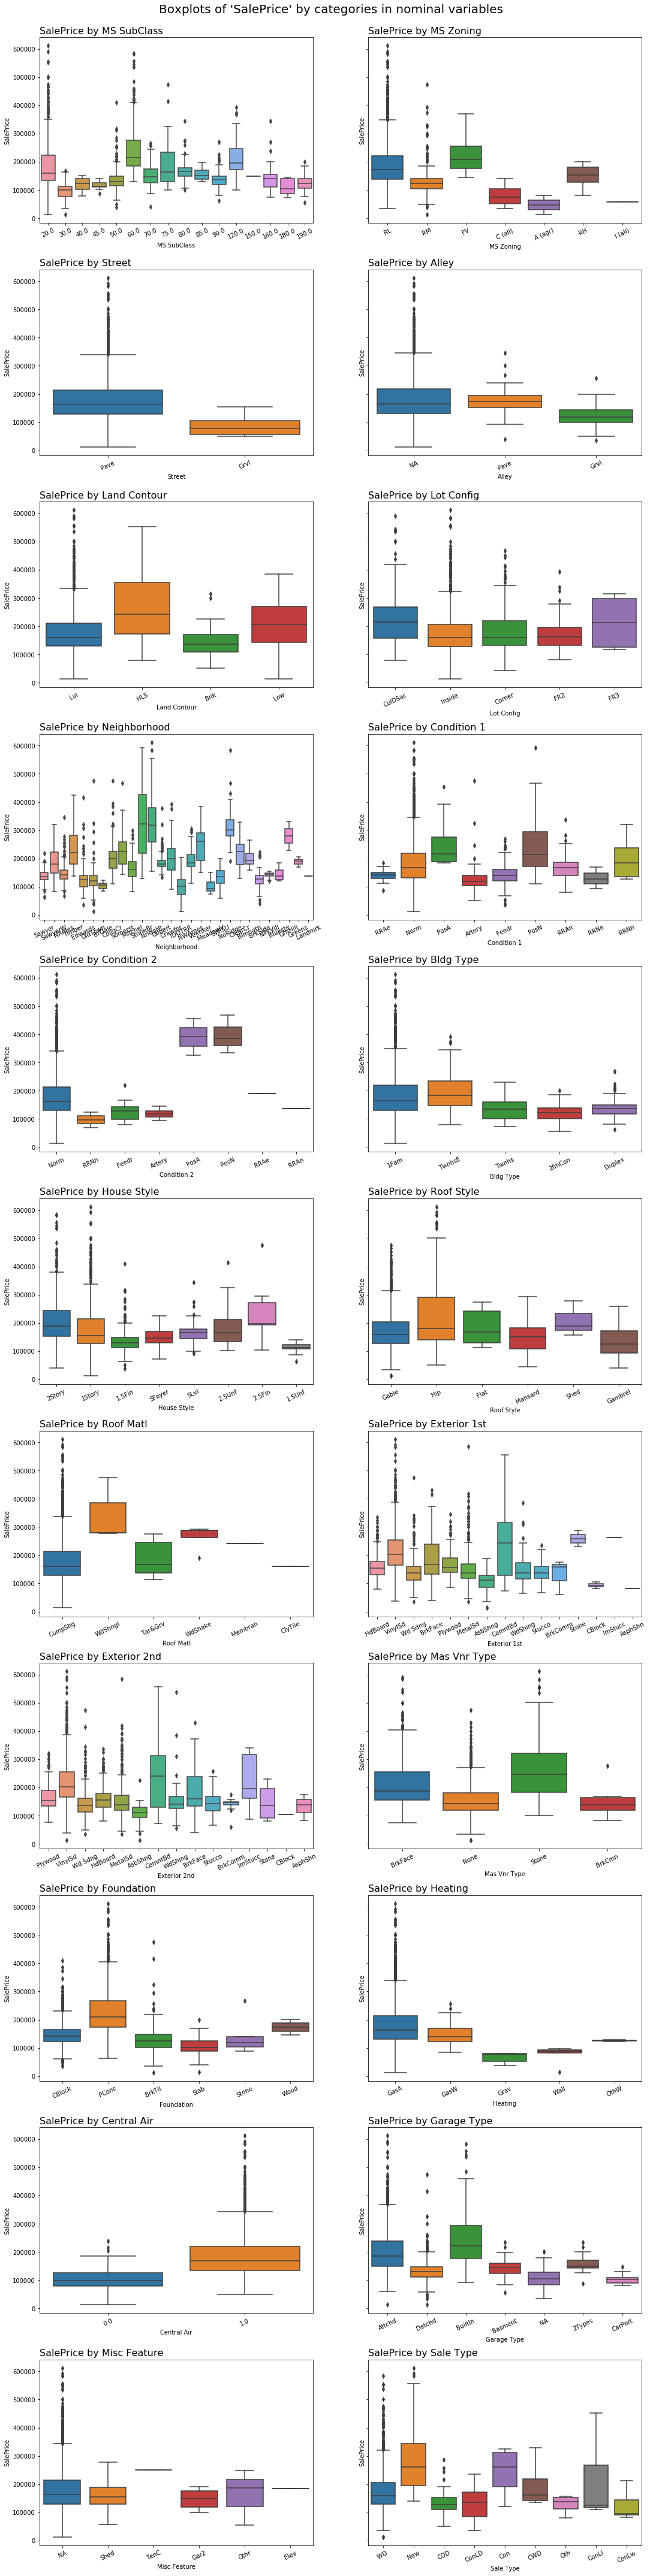

In [50]:
fig, ax = plt.subplots(nrows=11, ncols=2, figsize=(18,77), sharey=True)

ax = ax.ravel()

for i, col in enumerate(nominal_cols_dict):
    
    sns.boxplot(data=c_train, x=col, y='SalePrice', ax=ax[i])
    
    # Setting the title and x- and y-axis label rotation.
    ax[i].set_title(f"SalePrice by {col}", fontsize=16, loc='left')
    ax[i].tick_params(axis='x', labelrotation=25)
    ax[i].tick_params(axis='y', labelrotation=0)
    
fig.suptitle(x=0.5, y=0.89, t="Boxplots of 'SalePrice' by categories in nominal variables", fontsize=20)

# Adjusting the horizontal space between subplots to make the figure more clear.
plt.subplots_adjust(hspace=0.25)

# Exporting plot image in PNG format.
plt.savefig('../plot_images/boxplots_nominal_variables.png', bbox_inches='tight')

From the above heatmap and scatter plots, we deduce the following about categorical nominal variables:

- **Outliers**: Similar to ordinal variables above, there seems to be a presence of multiple points outside the whisker ranges in all of the boxplots above (*whis=1.5* by default). However, these points should not be termed as outliers directly, as there are a large number of such points (which means they represent the nature of the data spread in some way). So, these points do not need to be removed before proceeding.
- **Variables selected for next stage**: From the heatmap, I will select variables which have Kendall correlation coefficient of <= -0.2 & >= 0.2. So, the columns selected from this stage are: *'MS SubClass_30.0', 'MS SubClass_60.0', 'MS Zoning_RM', 'MS Zoning_RL', 'Neighborhood_OldTown', 'Neighborhood_NridgHt', 'House Style_2Story', 'Exterior 1st_VinylSd', 'Exterior 2nd_VinylSd', 'Mas Vnr Type_None', 'Mas Vnr Type_Stone', 'Mas Vnr Type_BrkFace', 'Foundation_CBlock', 'Foundation_PConc', 'Heating QC', 'Central Air', 'Garage Type_Detchd', 'Garage Type_NA', 'Garage Type_Attchd' & 'Sale Type_New'*.

In [51]:
# Filtering all selected variables for next stage.

nominal_selected_list = []

for col in nominal_cols_dict.keys():
    nominal_selected_list += list(nominal_cols_dict[col].T[(nominal_cols_dict[col].T['SalePrice'] >= 0.2) | (nominal_cols_dict[col].T['SalePrice'] <= -0.2)].index)

nominal_selected_list

['MS SubClass_30.0',
 'MS SubClass_60.0',
 'MS Zoning_RM',
 'MS Zoning_RL',
 'Neighborhood_OldTown',
 'Neighborhood_NridgHt',
 'House Style_2Story',
 'Exterior 1st_VinylSd',
 'Exterior 2nd_VinylSd',
 'Mas Vnr Type_None',
 'Mas Vnr Type_Stone',
 'Mas Vnr Type_BrkFace',
 'Foundation_CBlock',
 'Foundation_PConc',
 'Central Air',
 'Garage Type_Detchd',
 'Garage Type_NA',
 'Garage Type_Attchd',
 'Sale Type_New']

### Correlation between features

Now that I have a list of variables that are (somewhat) linearly related to the target variable *'SalePrice'*, I will consider another assumption of MLR, which is that of **independence of predictors** - *the predictor variables must be indepdent of one another*. In order to establish this, I will determine the correlation of all selected variables with one another, and then drop any variables from the list which have a high correlation (corr coef > 0.8). Kendall correlation method would be best suited for this, since we are comparing continuous, discrete & categorical (ordinal & nominal) variables with one another.

In [52]:
continuous_selected_list

['BsmtFin SF 1',
 'Wood Deck SF',
 'Lot Frontage',
 'Lot Area',
 'Mas Vnr Area',
 'Open Porch SF',
 '1st Flr SF',
 'Total Bsmt SF',
 'Garage Area',
 'Gr Liv Area']

In [53]:
discrete_selected_list

['Bsmt Full Bath',
 'Half Bath',
 'TotRms AbvGrd',
 'Fireplaces',
 'Year Remod/Add',
 'Garage Yr Blt',
 'Year Built',
 'Full Bath',
 'Garage Cars']

In [54]:
ordinal_selected_list

['Lot Shape',
 'Bsmt Cond',
 'Electrical',
 'Garage Cond',
 'Paved Drive',
 'Garage Qual',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'Heating QC',
 'Fireplace Qu',
 'Garage Finish',
 'Kitchen Qual',
 'Exter Qual',
 'Bsmt Qual',
 'Overall Qual']

In [55]:
nominal_selected_list

['MS SubClass_30.0',
 'MS SubClass_60.0',
 'MS Zoning_RM',
 'MS Zoning_RL',
 'Neighborhood_OldTown',
 'Neighborhood_NridgHt',
 'House Style_2Story',
 'Exterior 1st_VinylSd',
 'Exterior 2nd_VinylSd',
 'Mas Vnr Type_None',
 'Mas Vnr Type_Stone',
 'Mas Vnr Type_BrkFace',
 'Foundation_CBlock',
 'Foundation_PConc',
 'Central Air',
 'Garage Type_Detchd',
 'Garage Type_NA',
 'Garage Type_Attchd',
 'Sale Type_New']

In [56]:
# Combining lists of all types selected variables.

selected_var_list = continuous_selected_list + discrete_selected_list + ordinal_selected_list + nominal_selected_list
len(selected_var_list)

53

In [57]:
# Finding the Kendall correlation coefficient for all selected variable columns.

selected_var_corr_df = ce_train[selected_var_list].corr(method='kendall')

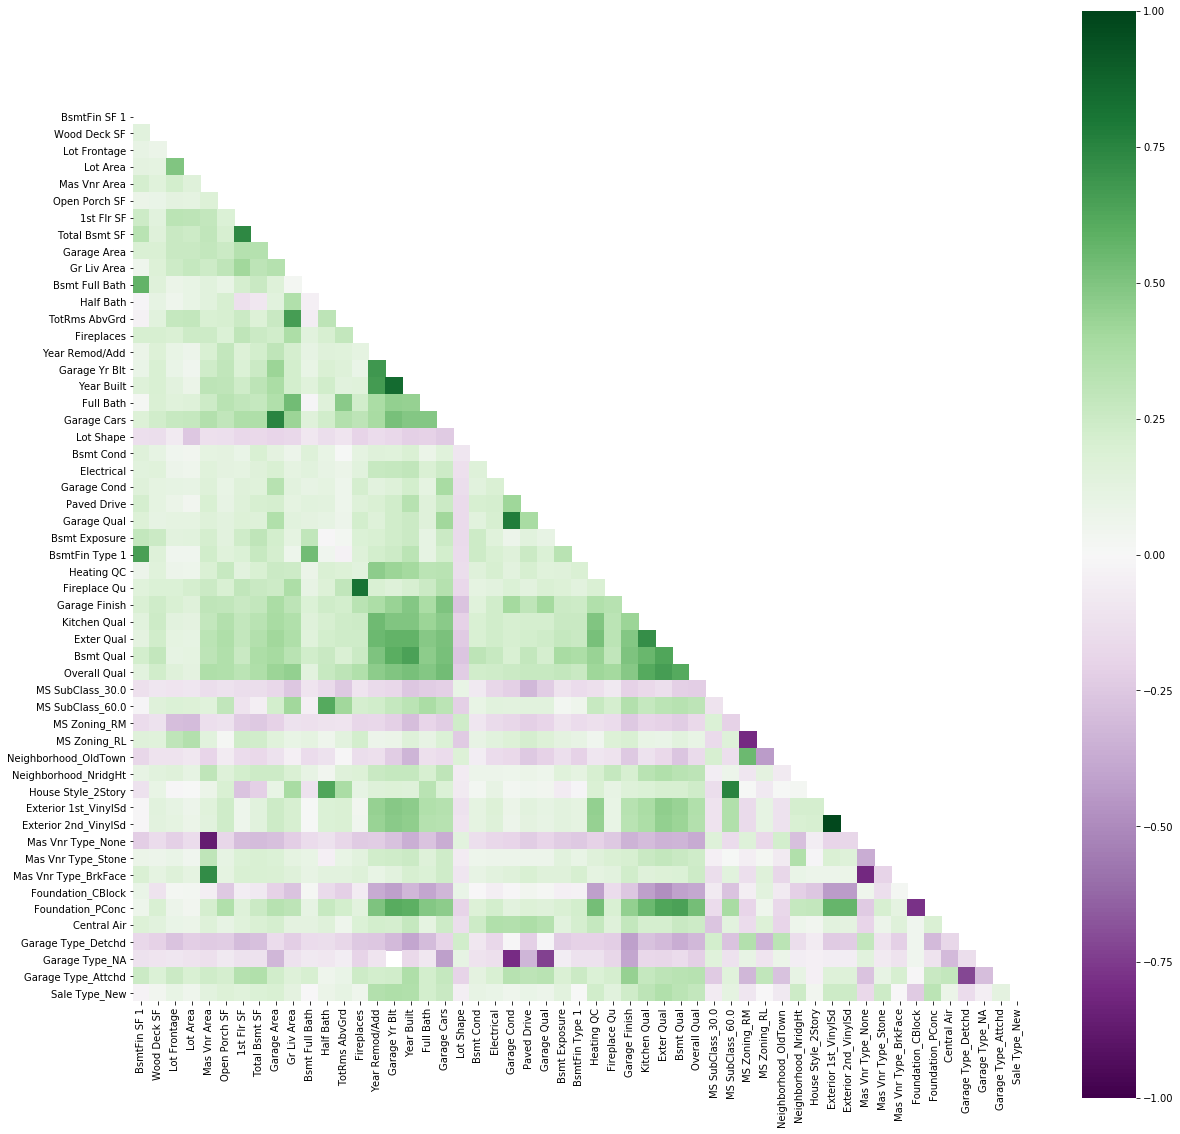

In [58]:
# Plotting the above in a heatmap to visualize the relationships.

plt.figure(figsize=(20,20))

# Generating a mask for the upper triangle.
mask = np.zeros_like(selected_var_corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(selected_var_corr_df, vmin=-1, vmax=1, mask=mask, square=True, cmap='PRGn')

# Exporting plot image in PNG format.
plt.savefig('../plot_images/heatmap_selected_variables.png', bbox_inches='tight')

The above heatmap is overwhelming, but we can see that there are a few predictor variables that are highly related to each other and may not be independent. I will determine these correlated predictors in the code below.

In [59]:
# Finding the highly correlated (non-indepdent) variables.

non_indep_var_list = []

for i in range(len(selected_var_corr_df.columns)):
    
    for j in range(i):
        
        if abs(selected_var_corr_df.iloc[i, j]) > 0.8:
            col = selected_var_corr_df.columns[i]
            non_indep_var_list.append(col)

non_indep_var_list

['Year Built',
 'Fireplace Qu',
 'MS Zoning_RL',
 'Exterior 2nd_VinylSd',
 'Mas Vnr Type_None',
 'Mas Vnr Type_BrkFace']

In [60]:
# Finding the highly correlated (non-indepdent) variables.
# Here we determine the variables that the above obtained variabled are related to.
# This is done so that I can choose which variable is better to be dropped, considering how many rows of missing data are in that column.

non_indep_var_list_2 = []

for i in range(len(selected_var_corr_df.columns)):
    
    for j in range(i):
        
        if abs(selected_var_corr_df.iloc[i, j]) > 0.8:
            col = selected_var_corr_df.columns[j]
            non_indep_var_list_2.append(col)

non_indep_var_list_2

['Garage Yr Blt',
 'Fireplaces',
 'MS Zoning_RM',
 'Exterior 1st_VinylSd',
 'Mas Vnr Area',
 'Mas Vnr Type_None']

In [61]:
# Checking list of columns which have one or more rows with np.nan values (list filtered at the beginning of the notebook).
# This is the number of remaining missing values in the dataframe.
# I will consider imputing this missing data if these columns are absolutely required in the regression model.

null_cols_ce_train

Lot Frontage     330
Mas Vnr Area      22
Garage Yr Blt    113
dtype: int64

Looking at the columns with null values above, *'Mas Vnr Area' & 'Garage Yr Blt'* columns have null values and they appear in *non_indep_var_list_2*, which means that they are highly correlated with some other selected variables above. So, in order to avoid imputing these null values, it is better to drop columns which appear in *non_indep_var_list_2* instead of *non_indep_var_list*.

In [62]:
# Removing highly correlated variables found in non_indep_var_list_2 from selected_var_list using list comprehension.

selected_var_list = [var for var in selected_var_list if var not in non_indep_var_list_2]
len(selected_var_list)

47

In [63]:
# Finding the Kendall correlation coefficient for all selected variable columns again.

selected_var_corr_df = ce_train[selected_var_list].corr(method='kendall')

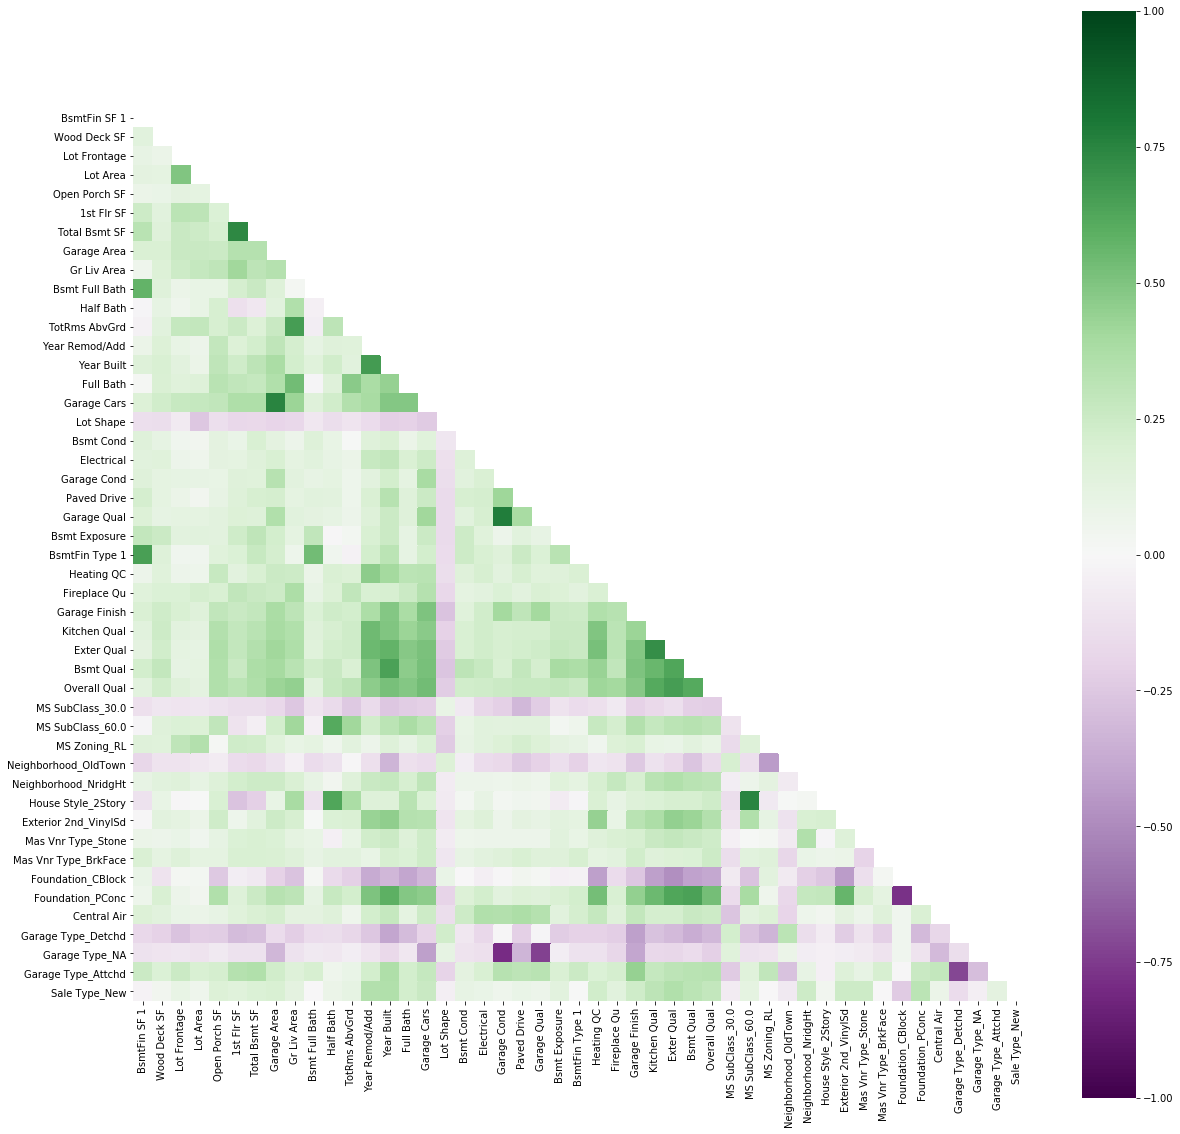

In [64]:
# Plotting the above in a heatmap to visualize the relationships.

plt.figure(figsize=(20,20))

# Generating a mask for the upper triangle.
mask = np.zeros_like(selected_var_corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(selected_var_corr_df, vmin=-1, vmax=1, mask=mask, square=True, cmap='PRGn')

# Exporting plot image in PNG format.
plt.savefig('../plot_images/heatmap_selected_variables_independent.png', bbox_inches='tight')

## Missing data imputation

Now that I have a list of selected variables and *'Lot Frontage'* is one of them, I will impute the missing data in *'Lot Frontage'* column before proceeding to feature selection and model building and evaluation.

In [65]:
# Checking number of null values in 'Lot Frontage' column.

ce_train['Lot Frontage'].isna().sum()

327

In [66]:
# Calculating mean of 'Lot Frontage' column to impute the missing data.

lot_frontage_mean = ce_train['Lot Frontage'].mean()
lot_frontage_mean

68.68187134502924

In [67]:
# Replacing all NaN values with the mean.

ce_train['Lot Frontage'].fillna(lot_frontage_mean, inplace=True)

In [68]:
# Checking number of null values in 'Lot Frontage' column again to ensure they were correctly imputed.

ce_train['Lot Frontage'].isna().sum()

0

In [69]:
# Checking mean of 'Lot Frontage' column again to ensure missing data was correctly imputed.
# Mean should still be the same as the value calculated above.

ce_train['Lot Frontage'].mean()

68.68187134502953

## Feature Selection, Model Building & Evaluation

Now that I have a more manageable list of 47 selected variables from the >200 variables I started with, I can apply some feature selection techniques and build models using them.

- RFECV with LinearRegression - obtain the best ranked features and build LinearRegression model with them
- RidgeCV - obtain optimal alpha value and build Ridge model with it
- LassoCV - obtain optimal alpha value and build Lasso model with it
- GridSearchCV with ElasticNet - obtain best values of alpha & l1_ratio and build ElasticNet model with it
- Step Forward Feature Selection

### Model Preparation

In [70]:
# Defining predictor variables X and target variable y.

X = ce_train[selected_var_list]
y = ce_train['SalePrice']

In [71]:
type(X)

pandas.core.frame.DataFrame

In [72]:
X.shape

(2037, 47)

In [73]:
y.shape

(2037,)

In [74]:
# Splitting our X & y into training and testing datasets.
# test_size = 0.2 is chosen because, compared to number of rows in test.csv (879), it gives us roughly twice the number of rows in X_train and roughly half the number of rows in X_test.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [75]:
X_train.shape

(1629, 47)

In [76]:
y_train.shape

(1629,)

In [77]:
X_test.shape

(408, 47)

In [78]:
y_test.shape

(408,)

In [79]:
# Scaling our X_train and X_test datasets using X_train. Target variable y datasets do not need ot be scaled.

ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

In [80]:
type(X_train_scaled)

numpy.ndarray

In [81]:
# Preparing dataframes from X_train_scaled and X_test_scaled so that it is easier to apply the masks created from our feature selection models later on.

X_train_scaled_df = pd.DataFrame(data=X_train_scaled, columns=selected_var_list)

X_test_scaled_df = pd.DataFrame(data=X_test_scaled, columns=selected_var_list)

### RFECV with LinearRegression - obtain the best ranked features and build LinearRegression model with them

In [82]:
# Instantiating our RFECV model with LinearRegression estimator.

lr_rfecv = RFECV(LinearRegression(),          # Estimator to be used in RFECV.
                 step=1,                      # No. of features to eliminate in each iteration (round) of elimination.
                 min_features_to_select=1,    # No. of features left until which rounds of elimination need to be repeated.
                 cv=5,                        # No. of cross validation in each round.
                 verbose=1
                )

In [83]:
# Fitting the model with X_train_scaled and y_train.

lr_rfecv.fit(X_train_scaled, y_train)

Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 fe

RFECV(cv=5,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=1)

In [84]:
# Estimates of r2 scores for subsets of features.
# For example, last value gives the estimated r2 score (mean of cv=5 r2 scores) of LinearRegression model built with all 47 selected features.
# 2nd to last value then gives estimated r2 score of LinearRegression model built with 46 top ranking features from first model built previously (step=1 lowest ranking feature is eliminated from first model).
# 3rd to last value then gives estimated r2 score of LinearRegression model built with 45 top ranking features from second model built previously (step=1 lowest ranking feature is eliminated from second model).
# And so on..

lr_rfecv.grid_scores_

array([0.65296663, 0.74843453, 0.79359847, 0.83265036, 0.8391864 ,
       0.84791939, 0.86168148, 0.86560332, 0.87162422, 0.87468153,
       0.87497025, 0.87691746, 0.8774337 , 0.87716779, 0.87770537,
       0.87845829, 0.87956491, 0.87971   , 0.88022492, 0.88068285,
       0.88120176, 0.88148281, 0.88080295, 0.88093744, 0.88096935,
       0.88134414, 0.8813784 , 0.88147615, 0.88169363, 0.88168817,
       0.88152178, 0.88167305, 0.88193799, 0.88196427, 0.88179873,
       0.88239759, 0.88258231, 0.88259338, 0.88275334, 0.88276183,
       0.88292262, 0.88277357, 0.88270385, 0.88267672, 0.88268618,
       0.88267653, 0.88266971])

In [85]:
# Optimal number of features suggested by RFECV model based on the scoring done by LinearRegression estimator (r2 score), as explained above.

lr_rfecv.n_features_

41

In [86]:
# Ranks of all 47 selected features. 28 features have rank 1, and will be used to build a LinearRegression model.

lr_rfecv.ranking_

array([1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 6, 1, 1, 1,
       1, 2, 1])

In [87]:
# Printing list of the 28 features suggested by the RFECV model.

[selected_var_list[i] for i in range(len(selected_var_list)) if lr_rfecv.ranking_[i]==1]

['BsmtFin SF 1',
 'Wood Deck SF',
 'Lot Frontage',
 'Lot Area',
 '1st Flr SF',
 'Total Bsmt SF',
 'Garage Area',
 'Gr Liv Area',
 'Bsmt Full Bath',
 'Half Bath',
 'TotRms AbvGrd',
 'Year Remod/Add',
 'Year Built',
 'Full Bath',
 'Garage Cars',
 'Bsmt Cond',
 'Electrical',
 'Paved Drive',
 'Garage Qual',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'Heating QC',
 'Fireplace Qu',
 'Garage Finish',
 'Kitchen Qual',
 'Exter Qual',
 'Bsmt Qual',
 'Overall Qual',
 'MS SubClass_30.0',
 'MS SubClass_60.0',
 'MS Zoning_RL',
 'Neighborhood_OldTown',
 'Neighborhood_NridgHt',
 'House Style_2Story',
 'Exterior 2nd_VinylSd',
 'Mas Vnr Type_Stone',
 'Foundation_PConc',
 'Central Air',
 'Garage Type_Detchd',
 'Garage Type_NA',
 'Sale Type_New']

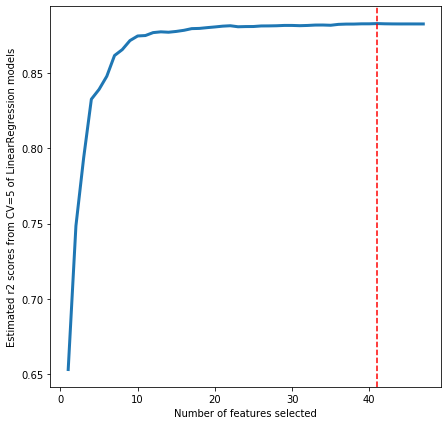

In [88]:
# Plotting the estimated r2 scores against number of features.

plt.figure(figsize=(7,7))

sns.lineplot(x=range(1, 48), y=lr_rfecv.grid_scores_, linewidth=3)

plt.axvline(lr_rfecv.n_features_, ls='--', color='r')

plt.xlabel("Number of features selected")
plt.ylabel("Estimated r2 scores from CV=5 of LinearRegression models");

# Exporting plot image in PNG format.
plt.savefig('../plot_images/RFECV_lin_reg_feature_selection.png', bbox_inches='tight')

In [89]:
# Mask of selected features from the RFECV model.

lr_rfecv.support_

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False,  True,  True,  True,  True,
       False,  True])

In [90]:
# Applying the mask on X_train_scaled_df and X_test_scaled_df to create new dataframes with the selected features.

X_train_scaled_lr_rfecv = X_train_scaled_df.iloc[:, lr_rfecv.support_]

X_test_scaled_lr_rfecv = X_test_scaled_df.iloc[:, lr_rfecv.support_]

In [91]:
# Checking the newly created X_train_scaled_lr_rfecv dataframe.

print(X_train_scaled_lr_rfecv.shape)
X_train_scaled_lr_rfecv.head()

(1629, 41)


BsmtFin SF 1  Wood Deck SF  Lot Frontage  Lot Area  1st Flr SF  \
0     -1.007620      0.813383      2.022287  0.900514   -0.234409   
1      3.152603      6.205033     -0.038774  8.371365    1.869768   
2      1.141446      3.172736     -0.004496 -0.376587    0.082173   
3     -0.883502      0.732305     -0.290123 -0.475875   -0.043368   
4     -0.536434      1.251201     -0.290123  0.515356   -0.149805   

   Total Bsmt SF  Garage Area  Gr Liv Area  Bsmt Full Bath  Half Bath  ...  \
0       0.021598     2.220728     1.421427       -0.829462   1.254138  ...   
1       1.901554     1.972615     0.730578        3.031091   1.254138  ...   
2       0.274994    -0.246367    -0.640653        1.100814  -0.739024  ...   
3       0.209835     0.053243    -0.736953        1.100814   1.254138  ...   
4       0.096410     0.947389     2.051565       -0.829462   1.254138  ...   

   Neighborhood_OldTown  Neighborhood_NridgHt  House Style_2Story  \
0             -0.295719              3.952524            1.565654   
1             -0.295719             -0.253003           -0.638711   
2             -0.295719             -0.253003           -0.638711   
3             -0.295719             -0.253003           -0.638711   
4             -0.295719             -0.253003            1.565654   

   Exterior 2nd_VinylSd  Mas Vnr Type_Stone  Foundation_PConc  Central Air  \
0              1.344850           -0.299386          1.102872     0.273017   
1             -0.743578           -0.299386         -0.906724     0.273017   
2             -0.743578           -0.299386          1.102872     0.273017   
3              1.344850           -0.299386          1.102872     0.273017   
4              1.344850           -0.299386          1.102872     0.273017   

   Garage Type_Detchd  Garage Type_NA  Sale Type_New  
0           -0.600751         -0.2404       3.381585  
1           -0.600751         -0.2404      -0.295719  
2           -0.600751         -0.2404      -0.295719  
3            1.664582         -0.2404      -0.295719  
4           -0.600751         -0.2404       3.381585  

[5 rows x 41 columns]

In [92]:
# Checking the newly created X_test_scaled_lr_rfecv dataframe.

print(X_test_scaled_lr_rfecv.shape)
X_test_scaled_lr_rfecv.head()

(408, 41)


BsmtFin SF 1  Wood Deck SF  Lot Frontage  Lot Area  1st Flr SF  \
0     -0.129606      2.110622     -2.401453 -1.679750   -1.724526   
1     -0.497360     -0.743305      1.569859  0.569138   -0.452741   
2      0.297909      0.335026     -0.004496  0.497360   -0.493678   
3     -1.007620      0.424211     -0.004496 -0.475875   -0.559178   
4      1.670093     -0.743305     -0.004496  1.178522    4.751752   

   Total Bsmt SF  Garage Area  Gr Liv Area  Bsmt Full Bath  Half Bath  ...  \
0      -1.276754    -0.976664    -0.839534       -0.829462   1.254138  ...   
1      -0.152159     0.961433     0.950393       -0.829462   1.254138  ...   
2      -0.535873    -0.134013     1.243481       -0.829462   1.254138  ...   
3      -0.246277    -0.016978     0.667773       -0.829462   1.254138  ...   
4       1.233071     0.900575     2.941295        1.100814  -0.739024  ...   

   Neighborhood_OldTown  Neighborhood_NridgHt  House Style_2Story  \
0             -0.295719             -0.253003            1.565654   
1             -0.295719             -0.253003            1.565654   
2             -0.295719             -0.253003            1.565654   
3             -0.295719             -0.253003            1.565654   
4             -0.295719             -0.253003           -0.638711   

   Exterior 2nd_VinylSd  Mas Vnr Type_Stone  Foundation_PConc  Central Air  \
0             -0.743578           -0.299386         -0.906724     0.273017   
1              1.344850           -0.299386          1.102872     0.273017   
2             -0.743578           -0.299386         -0.906724     0.273017   
3              1.344850           -0.299386          1.102872     0.273017   
4             -0.743578           -0.299386         -0.906724     0.273017   

   Garage Type_Detchd  Garage Type_NA  Sale Type_New  
0            1.664582         -0.2404      -0.295719  
1           -0.600751         -0.2404      -0.295719  
2           -0.600751         -0.2404      -0.295719  
3           -0.600751         -0.2404      -0.295719  
4           -0.600751         -0.2404      -0.295719  

[5 rows x 41 columns]

In [93]:
# Creating a new LinearRegression model with 28 selected features suggested by RFECV above.

lr = LinearRegression()
lr.fit(X_train_scaled_lr_rfecv, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [94]:
lr.coef_

array([11271.60015536,  1097.04885273,  2217.53721978,  5811.05101821,
        -607.78205122,  6656.42283769,  4256.45484176, 26688.61369059,
         722.18066304,   900.03736772, -1706.76393598,  2277.77408345,
        2905.9616549 , -3302.67464616,  1019.58755716, -2916.30521486,
        -861.501681  ,   765.70981079,  3698.78982654,  3899.65029639,
       -1202.09446913,  2393.71647027,  3012.84971665,  2793.57375647,
        6645.46256307,  6781.93537404,  1576.02260742, 18265.22231055,
        1909.64771716,  1559.82229391,  1337.52803775, -1234.68279357,
        5098.07652112, -3183.4605775 , -1469.51126906,  1402.21242987,
        1012.48915794,   606.08526146,  2243.69426694,  6622.08518696,
        5268.93648466])

In [95]:
lr.intercept_

180761.18968692448

In [96]:
# Estimated test r2 score from 5 cross validations.

cross_val_score(lr, X_train_scaled_lr_rfecv, y_train, cv=5, scoring='r2').mean()

0.8835176542211262

In [97]:
# Spread of train r2 scores from 5 cross validations.

cross_val_score(lr, X_train_scaled_lr_rfecv, y_train, cv=5, scoring='r2').std()

0.01834988542142458

In [98]:
# Estimated test MSE from 5 cross validations.

-cross_val_score(lr, X_train_scaled_lr_rfecv, y_train, cv=5, scoring='neg_mean_squared_error').mean()

695284495.3072885

In [99]:
# Spread of train MSE from 5 cross validations.

(-cross_val_score(lr, X_train_scaled_lr_rfecv, y_train, cv=5, scoring='neg_mean_squared_error')).std()

131672863.82188775

In [100]:
# Estimated test RMSE from 5 cross validations.

np.sqrt(-cross_val_score(lr, X_train_scaled_lr_rfecv, y_train, cv=5, scoring='neg_mean_squared_error').mean())

26368.247861913173

In [101]:
# Generating test predictions from the model

pred_1 = lr.predict(X_test_scaled_lr_rfecv)

In [102]:
# Actual test r2 score.

r2_score(y_test, pred_1)

0.8808188449686132

In [103]:
# Actual test MSE.

mean_squared_error(y_test, pred_1)

881921484.9939429

In [104]:
# Actual test RMSE.

np.sqrt(mean_squared_error(y_test, pred_1))

29697.16291152983

In [105]:
data_1 = {'model_desc' : 'RFECV, LinReg',
          'est_test_r2' : cross_val_score(lr, X_train_scaled_lr_rfecv, y_train, cv=5, scoring='r2').mean(),
          'est_test_r2_std' : cross_val_score(lr, X_train_scaled_lr_rfecv, y_train, cv=5, scoring='r2').std(),
          'est_test_MSE' : -cross_val_score(lr, X_train_scaled_lr_rfecv, y_train, cv=5, scoring='neg_mean_squared_error').mean(),
          'est_test_RMSE' : np.sqrt(-cross_val_score(lr, X_train_scaled_lr_rfecv, y_train, cv=5, scoring='neg_mean_squared_error').mean()),
          'act_test_r2' : r2_score(y_test, pred_1),
          'act_test_MSE' : mean_squared_error(y_test, pred_1),
          'act_test_RMSE' : np.sqrt(mean_squared_error(y_test, pred_1)),
          'remarks' : 'RFECV selected 28 out of 47 features. LinReg model built on 28 selected features.'
         }

In [106]:
# Creating a dataframe to summarise all scores.

summary_df = pd.DataFrame(data=data_1, index=[1])
summary_df

model_desc  est_test_r2  est_test_r2_std  est_test_MSE  est_test_RMSE  \
1  RFECV, LinReg     0.883518          0.01835  6.952845e+08   26368.247862   

   act_test_r2  act_test_MSE  act_test_RMSE  \
1     0.880819  8.819215e+08   29697.162912   

                                             remarks  
1  RFECV selected 28 out of 47 features. LinReg m...

## RidgeCV - obtain optimal alpha value and build Ridge model with it

In [107]:
# Instantiating the RidgeCV model and passing in range of alpha values to determine optimal alpha from.
# We leave the default CV to be Leave One Out CV (LOOCV).
# RidgeCV, by default, gives the mean squared error as score.

r_alphas = np.logspace(0, 5, 200)
ridgecv = RidgeCV(alphas=r_alphas, store_cv_values=True)

In [108]:
# Fitting the model with X_train_scaled and y_train.

ridgecv.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.05956018e+00, 1.12266777e+00, 1.18953407e+00,
       1.26038293e+00, 1.33545156e+00, 1.41499130e+00, 1.49926843e+00,
       1.58856513e+00, 1.68318035e+00, 1.78343088e+00, 1.88965234e+00,
       2.00220037e+00, 2.12145178e+00, 2.24780583e+00, 2.38168555e+00,
       2.52353917e+00, 2.67384162e+00, 2.83309610e+00, 3.00183581e+00,
       3.18062569e+00, 3.37006433e+0...
       3.33129479e+04, 3.52970730e+04, 3.73993730e+04, 3.96268864e+04,
       4.19870708e+04, 4.44878283e+04, 4.71375313e+04, 4.99450512e+04,
       5.29197874e+04, 5.60716994e+04, 5.94113398e+04, 6.29498899e+04,
       6.66991966e+04, 7.06718127e+04, 7.48810386e+04, 7.93409667e+04,
       8.40665289e+04, 8.90735464e+04, 9.43787828e+04, 1.00000000e+05]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=True)

In [109]:
# Optimal value of alpha obtained from RidgeCV.

ridgecv.alpha_

18.041864093920726

In [110]:
# Estimated test RMSEs for each individual value of alpha passed into RidgeCV.

ridge_cv_rmse = [np.sqrt(np.mean(cv_alpha)) for cv_alpha in ridgecv.cv_values_.T]
ridge_cv_rmse

[26341.056005907692,
 26340.929126345287,
 26340.795429668047,
 26340.654597680987,
 26340.506303472735,
 26340.350212053603,
 26340.185981155886,
 26340.013262218257,
 26339.831701578296,
 26339.640941899543,
 26339.440623862254,
 26339.230388149634,
 26339.009877764165,
 26338.778740711972,
 26338.536633096035,
 26338.283222662634,
 26338.018192848624,
 26337.741247380603,
 26337.45211548066,
 26337.150557736393,
 26336.836372696565,
 26336.509404256627,
 26336.16954990092,
 26335.81676987117,
 26335.45109733221,
 26335.072649607166,
 26334.681640554598,
 26334.27839415924,
 26333.863359405743,
 26333.437126501456,
 26333.000444508874,
 26332.55424044115,
 26332.099639864493,
 26331.637989039504,
 26331.170878618646,
 26330.700168899577,
 26330.22801661335,
 26329.7569032026,
 26329.289664517622,
 26328.829521827887,
 26328.380114013056,
 26327.945530761237,
 26327.530346563908,
 26327.139655256437,
 26326.779104812475,
 26326.454932059707,
 26326.173996945567,
 26325.94381594579,
 2

In [111]:
# Initiating a LinearRegression model to act as baseline for comparison.

lr2 = LinearRegression()

lr_cv_mean_rmse = np.sqrt(-cross_val_score(lr2, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error').mean())
lr_cv_mean_rmse

26468.642800631394

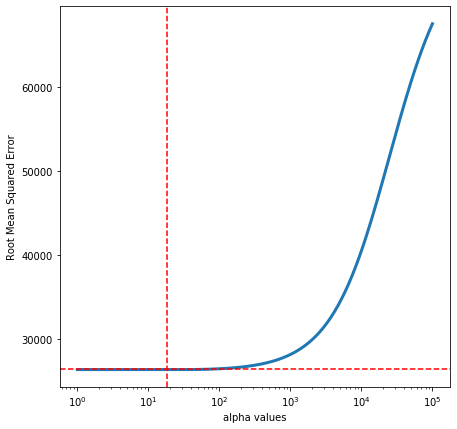

In [112]:
# Plotting obtained RMSE values against values of alpha.

plt.figure(figsize=(7,7))

plt.xscale('log')

sns.lineplot(x=r_alphas, y=ridge_cv_rmse, linewidth=3)

plt.axvline(ridgecv.alpha_, ls='--', color='r')
plt.axhline(lr_cv_mean_rmse, ls='--', color='r')

plt.xlabel("alpha values")
plt.ylabel("Root Mean Squared Error")

# Exporting plot image in PNG format.
plt.savefig('../plot_images/RidgeCV_optimal_alpha.png', bbox_inches='tight');

In [113]:
# Creating a new Ridge model with optimal alpha value suggested by RidgeCV above.

ridge = Ridge(alpha=ridgecv.alpha_)
ridge.fit(X_train_scaled, y_train)

Ridge(alpha=18.041864093920726, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [114]:
ridge.coef_

array([10947.13302992,  1176.53607919,  2272.85120373,  5631.11197188,
         423.37531047,  1047.73306544,  6182.01414393,  4373.45407808,
       24048.87688517,   816.05106259,  1373.62543852,  -895.58408399,
        2110.63469898,  2196.38801402, -2697.84946765,  1012.59006352,
        -434.69687884, -2838.26069659,  -833.36105567,   186.82151896,
         807.40430221,  2821.78917719,  3953.12396577,  -992.21830151,
        2463.65547057,  3236.76068107,  2647.67785647,  6715.63562838,
        6840.99221597,  1887.62340327, 17767.06050085,  1611.13466599,
        1715.91213184,  1191.66734622, -1255.75225372,  5063.71328962,
       -2476.92440278, -1383.61213518,  1382.6373529 ,   -64.89901207,
        -292.97516034,   805.94570377,   688.2931298 ,  2259.35904845,
        5875.14896916,   182.84502245,  5179.17212698])

In [115]:
ridge.intercept_

180761.18968692448

In [116]:
# Estimated test r2 score from 5 cross validations.

cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='r2').mean()

0.8829954602420361

In [117]:
# Spread of train r2 scores from 5 cross validations.

cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='r2').std()

0.017783936140395615

In [118]:
# Estimated test MSE from 5 cross validations.

-cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error').mean()

699088732.550967

In [119]:
# Spread of train MSE from 5 cross validations.

(-cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')).std()

132133024.88364686

In [120]:
# Estimated test RMSE from 5 cross validations.

np.sqrt(-cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error').mean())

26440.28616620794

In [121]:
# Generating test predictions from the model

pred_2 = ridge.predict(X_test_scaled)

In [122]:
# Actual test r2 score.

r2_score(y_test, pred_2)

0.880961239542625

In [123]:
# Actual test MSE.

mean_squared_error(y_test, pred_2)

880867787.9213266

In [124]:
# Actual test RMSE.

np.sqrt(mean_squared_error(y_test, pred_2))

29679.416906693546

In [125]:
data_2 = {'model_desc' : 'RidgeCV, Ridge',
          'est_test_r2' : cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='r2').mean(),
          'est_test_r2_std' : cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='r2').std(),
          'est_test_MSE' : -cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error').mean(),
          'est_test_RMSE' : np.sqrt(-cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error').mean()),
          'act_test_r2' : r2_score(y_test, pred_2),
          'act_test_MSE' : mean_squared_error(y_test, pred_2),
          'act_test_RMSE' : np.sqrt(mean_squared_error(y_test, pred_2)),
          'remarks' : f'RidgeCV suggested optimal alpha = {ridgecv.alpha_}.'
         }

In [126]:
summary_df = summary_df.append(pd.DataFrame(data=data_2, index=[2]))
summary_df

model_desc  est_test_r2  est_test_r2_std  est_test_MSE  est_test_RMSE  \
1   RFECV, LinReg     0.883518         0.018350  6.952845e+08   26368.247862   
2  RidgeCV, Ridge     0.882995         0.017784  6.990887e+08   26440.286166   

   act_test_r2  act_test_MSE  act_test_RMSE  \
1     0.880819  8.819215e+08   29697.162912   
2     0.880961  8.808678e+08   29679.416907   

                                             remarks  
1  RFECV selected 28 out of 47 features. LinReg m...  
2  RidgeCV suggested optimal alpha = 18.041864093...

## LassoCV - obtain optimal alpha value and build Lasso model with it

In [ ]:
# Instantiating the RidgeCV model and passing in range of alpha values to determine optimal alpha from.
# We leave the default CV to be Leave One Out CV (LOOCV).
# RidgeCV, by default, gives the mean squared error as score.

r_alphas = np.logspace(0, 5, 200)
ridgecv = RidgeCV(alphas=r_alphas, store_cv_values=True)

In [ ]:
# Fitting the model with X_train_scaled and y_train.

ridgecv.fit(X_train_scaled, y_train)

In [ ]:
# Optimal value of alpha obtained from RidgeCV.

ridgecv.alpha_

In [ ]:
# Estimated test RMSEs for each individual value of alpha passed into RidgeCV.

ridge_cv_rmse = [np.sqrt(np.mean(cv_alpha)) for cv_alpha in ridgecv.cv_values_.T]
ridge_cv_rmse

In [ ]:
# Initiating a LinearRegression model to act as baseline for comparison.

lr2 = LinearRegression()

lr_cv_mean_rmse = np.sqrt(-cross_val_score(lr2, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error').mean())
lr_cv_mean_rmse

In [ ]:
# Plotting obtained RMSE values against values of alpha.

plt.figure(figsize=(7,7))

plt.xscale('log')

sns.lineplot(x=r_alphas, y=ridge_cv_rmse, linewidth=3)

plt.axvline(ridgecv.alpha_, ls='--', color='r')
plt.axhline(lr_cv_mean_rmse, ls='--', color='r')

plt.xlabel("alpha values")
plt.ylabel("Root Mean Squared Error")

# Exporting plot image in PNG format.
plt.savefig('../plot_images/RidgeCV_optimal_alpha.png', bbox_inches='tight');

In [ ]:
# Creating a new Ridge model with optimal alpha value suggested by RidgeCV above.

ridge = Ridge(alpha=ridgecv.alpha_)
ridge.fit(X_train_scaled, y_train)

In [ ]:
ridge.coef_

In [ ]:
ridge.intercept_

In [ ]:
# Estimated test r2 score from 5 cross validations.

cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='r2').mean()

In [ ]:
# Spread of train r2 scores from 5 cross validations.

cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='r2').std()

In [ ]:
# Estimated test MSE from 5 cross validations.

-cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error').mean()

In [ ]:
# Spread of train MSE from 5 cross validations.

(-cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')).std()

In [ ]:
# Estimated test RMSE from 5 cross validations.

np.sqrt(-cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error').mean())

In [ ]:
# Generating test predictions from the model

pred_2 = ridge.predict(X_test_scaled)

In [ ]:
# Actual test r2 score.

r2_score(y_test, pred_2)

In [ ]:
# Actual test MSE.

mean_squared_error(y_test, pred_2)

In [ ]:
# Actual test RMSE.

np.sqrt(mean_squared_error(y_test, pred_2))

In [ ]:
data_2 = {'model_desc' : 'RidgeCV, Ridge',
          'est_test_r2' : cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='r2').mean(),
          'est_test_r2_std' : cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='r2').std(),
          'est_test_MSE' : -cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error').mean(),
          'est_test_RMSE' : np.sqrt(-cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error').mean()),
          'act_test_r2' : r2_score(y_test, pred_2),
          'act_test_MSE' : mean_squared_error(y_test, pred_2),
          'act_test_RMSE' : np.sqrt(mean_squared_error(y_test, pred_2)),
          'remarks' : f'RidgeCV suggested optimal alpha = {ridgecv.alpha_}.'
         }

In [ ]:
summary_df = summary_df.append(pd.DataFrame(data=data_2, index=[2]))
summary_df

In [ ]:
# Instantiate our GridSearchCV object.
knn_gridsearch = GridSearchCV(KNeighborsClassifier(), # What is the model we want to fit?
                              knn_params, # What is the dictionary of hyperparameters?
                              cv=5, # What number of folds in CV will we use?
                              verbose=1)

Automatically created module for IPython interactive environment
Optimal number of features : 3


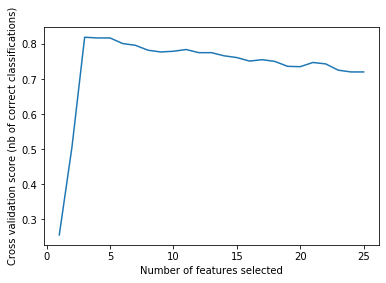

In [18]:
print(__doc__)

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Build a classification task using 3 informative features
X, y = make_classification(n_samples=1000, n_features=25, n_informative=3,
                           n_redundant=2, n_repeated=0, n_classes=8,
                           n_clusters_per_class=1, random_state=0)

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [197]:
colu = ['a', 'b', 'c']
datu = {'a':'a', 'b':2, 'c':3}

In [198]:
mydf = pd.DataFrame(data=datu, index=[0])

In [199]:
mydf

a  b  c
0  a  2  3

In [200]:
mydf.loc[0, :]

a    a
b    2
c    3
Name: 0, dtype: object

In [201]:
mydf

a  b  c
0  a  2  3

In [66]:
# Function to calculate Cramer's V correlation coefficient.
# Code borrowed from https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [107]:
# Filtering all columns that need one-hot encoding (all nominal columns).
# These columns will be used to calculate the Cramer's V correlation coefficient against 'SalePrice' column.

categorical_corr_df = pd.DataFrame(data_dict.loc[data_dict['Needs one-hot encoding']=='yes', 'Column name'])

#Creating an extra column 'SalePrice' of 0 values. These values will be replaced with the Cramer's V correlation coefficient.
categorical_corr_df['SalePrice'] = 0

# Setting 'Column name' column as index.
categorical_corr_df.set_index('Column name', inplace=True)

# Transposing the dataframe to make indices into columns.
categorical_corr_df = categorical_corr_df.T

categorical_corr_df

Column name  MS SubClass  MS Zoning  Street  Alley  Land Contour  Lot Config  \
SalePrice              0          0       0      0             0           0   

Column name  Neighborhood  Condition 1  Condition 2  Bldg Type  ...  \
SalePrice               0            0            0          0  ...   

Column name  Roof Style  Roof Matl  Exterior 1st  Exterior 2nd  Mas Vnr Type  \
SalePrice             0          0             0             0             0   

Column name  Foundation  Heating  Garage Type  Misc Feature  Sale Type  
SalePrice             0        0            0             0          0  

[1 rows x 21 columns]

In [204]:
# Finding the Cramer's V correlation coefficient for all categorical columns.

for col in categorical_corr_df.columns:
    cramer_coef = cramers_v(c_train[col], c_train['SalePrice'])
    categorical_corr_df.loc['SalePrice', col] = cramer_coef
    
categorical_corr_df

Column name  MS SubClass  MS Zoning    Street   Alley  Land Contour  \
SalePrice       0.177916   0.490381  0.655845  0.0751      0.249635   

Column name  Lot Config  Neighborhood  Condition 1  Condition 2  Bldg Type  \
SalePrice           0.0      0.132572     0.071204     0.296134        0.0   

Column name  ...  Roof Style  Roof Matl  Exterior 1st  Exterior 2nd  \
SalePrice    ...         0.0    0.04207      0.302921           0.0   

Column name  Mas Vnr Type  Foundation  Heating  Garage Type  Misc Feature  \
SalePrice        0.249683    0.407634      0.0     0.170021      0.351669   

Column name  Sale Type  
SalePrice     0.270748  

[1 rows x 21 columns]

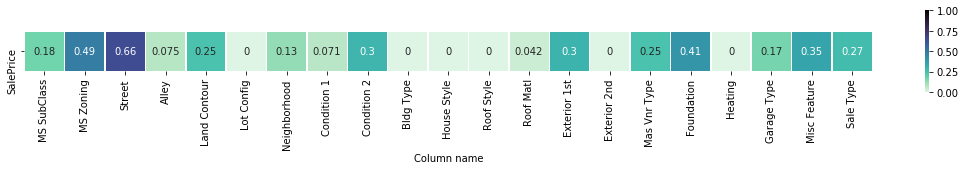

In [256]:
# Plotting the above in a heatmap to visualize the relationship.

plt.figure(figsize=(19,1.5))

sns.heatmap(categorical_corr_df, vmin=0, vmax=1, annot=True, square=True, linewidths=0.5, cmap='mako_r')

In [161]:
x = [1, 2, 3, 4, 5, 6, 7]
y = [2, 5, 6]

In [164]:
[i for i in x if i not in y]

[1, 3, 4, 7]

In [30]:
p_corr = ce_train.corr()

for i in p_corr.index:
    for j in p_corr.columns:
        if -0.2 < p_corr[i][j] < 0.2:
            p_corr[i][j]=0

In [31]:
len(p_corr[p_corr['SalePrice']!=0]['SalePrice'])-1

62

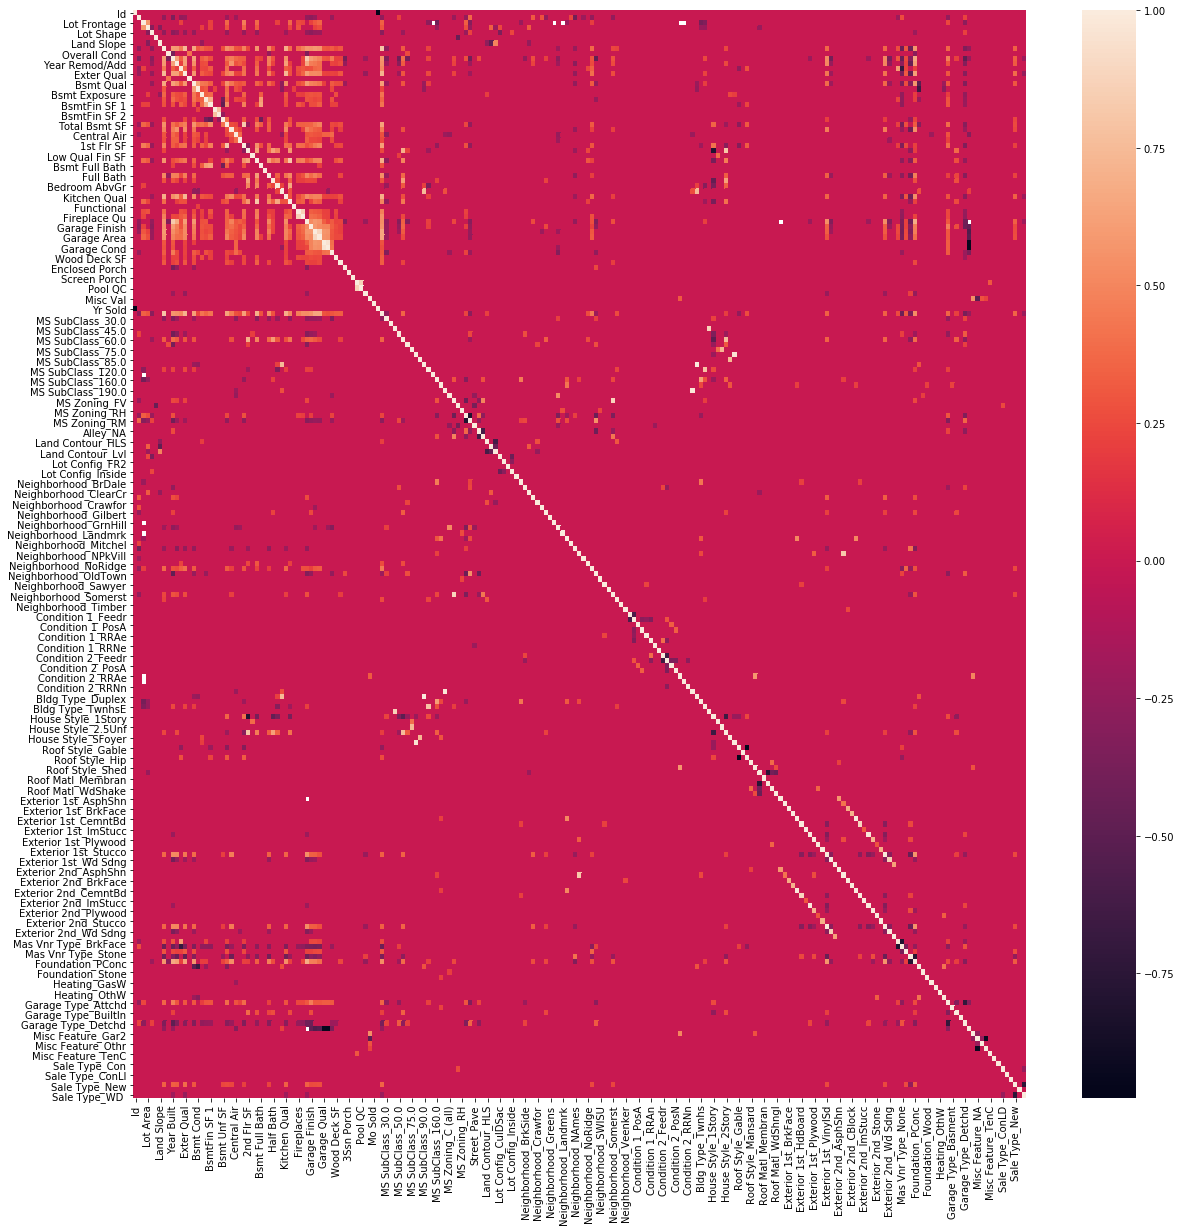

In [32]:
plt.figure(figsize=(20,20))

sns.heatmap(p_corr)

In [218]:
mylist = [col for col in ce_train.columns if 'Lot Config' in col]

In [220]:
mylist.append('SalePrice')

In [223]:
ce_train[mylist].corr()['SalePrice']

Lot Config_Corner    -0.004879
Lot Config_CulDSac    0.162922
Lot Config_FR2       -0.014678
Lot Config_FR3        0.025429
Lot Config_Inside    -0.084031
SalePrice             1.000000
Name: SalePrice, dtype: float64

In [224]:
mylist_street = [col for col in ce_train.columns if 'Street' in col]

In [225]:
mylist_street.append('SalePrice')

In [226]:
ce_train[mylist_street].corr()['SalePrice']

Street_Grvl   -0.069882
Street_Pave    0.069882
SalePrice      1.000000
Name: SalePrice, dtype: float64



Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r

In [12]:
features = ['Utilities', 'Year Built']

In [13]:
X = ce_train[features]
y = ce_train['SalePrice']

In [15]:
X.shape

(2044, 2)

In [16]:
y.shape

(2044,)

In [14]:
lm = LinearRegression()

In [17]:
lm.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
lm.predict(X)

array([187895.73640563, 217944.65306677, 153339.48224532, ...,
       115778.3364189 , 157846.81974449, 222451.99056594])

In [19]:
lm.score(X, y)

0.32726030597061806

In [20]:
X_test = ce_test[features]

In [21]:
pred = lm.predict(X_test)

In [22]:
pred

array([ 88734.31142387, 189398.18223869, 232969.11139734, 108266.10725361,
       168363.94057589, 181885.9530734 , 160851.71141061, 189398.18223869,
       229964.21973123, 189398.18223869, 210432.42390149, 111270.99891972,
       154841.92807838, 223954.436399  , 109768.55308667, 159349.26557755,
       133807.68641558, 157846.81974449, 165359.04890978,  46665.82809827,
       175876.16974118, 165359.04890978, 213437.3155676 , 177378.61557423,
       234471.5572304 , 181885.9530734 , 103758.76975444,  43660.93643216,
       168363.94057589, 141319.91558086, 180383.50724035, 111270.99891972,
        43660.93643216, 183388.39890646, 225456.88223206, 232969.11139734,
       103758.76975444, 141319.91558086, 153339.48224532, 222451.99056594,
       237476.44889651, 220949.54473289, 162354.15724366, 150334.59057921,
       204422.64056926, 178881.06140729, 225456.88223206, 171368.832242  ,
       157846.81974449, 168363.94057589, 118783.22808501,  58685.39476273,
       234471.5572304 , 1

In [26]:
submission = pd.DataFrame(pred, columns=['SalePrice'])

In [40]:
sub = ce_test[['Id']].sort_values(by='Id').astype(int)

In [42]:
sub['SalePrice'] = pred

In [43]:
sub

Id      SalePrice
704     2   88734.311424
706     4  189398.182239
120     6  232969.111397
312     7  108266.107254
401    17  168363.940576
..    ...            ...
537  2919  184890.844740
179  2921  172871.278075
829  2922  175876.169741
669  2925  180383.507240
675  2928  156344.373911

[879 rows x 2 columns]

In [44]:
sub.to_csv('../datasets/submission_0.csv', index=False)